# TO DO

1) Add cross-validation

2) Use some optimization library (tune, for ex) 

    * (in future - maybe try own implementation of genetic algorithm)

3) Add optimizer to input gradient descent 
    * (make training procedure for input training) 

~~4) Write recommendation letters for zhores ~~

~~5) Fill presentation~~

6) Write article 

  ~~* (find template)~~
    
7) Recalculate databases for 9 elements

8) Нормировать лейблы (минус среднее и разделить на среднеквадратичное отклонение)

9) Batch size 128 doesnt work


In [1]:
%load_ext tensorboard

In [3]:
path="./"

In [4]:
import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler


In [5]:
import load_data_multitox as ld
import dataloaders_sigma as dl
from Model_train_test_regression import Net, EarlyStopping, train, test

import pandas as pd
import numpy as np

import torch
from torch.utils import data as td
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
# from torchsummary import summary

import sys 
import os
import glob

from sklearn.model_selection import train_test_split

from tensorboardX import SummaryWriter

import time
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import json
import glob
import sqlite3

In [6]:
# number of conformers created for every molecule
NUM_CONFS = 100

# amount of chemical elements taking into account
AMOUNT_OF_ELEM = 9

# amount of target values
TARGET_NUM = 29

#dataset folder
# DATASET_PATH="~/Tox21-MultiTox/MultiTox"
DATASET_PATH=os.path.join(path)

#logs path

LOG_PATH=os.path.join(path,"logs_sigma_right")


#models path
MODEL_PATH=os.path.join(path,"models_sigma_right")

EXPERIMENT_NUM=21

In [7]:
dir_path = os.path.join(LOG_PATH,'exp_'+str(EXPERIMENT_NUM))
os.makedirs(dir_path, exist_ok=True)
LOG_PATH = dir_path
dir_path = os.path.join(MODEL_PATH,'exp_'+str(EXPERIMENT_NUM))
os.makedirs(dir_path, exist_ok=True)
MODEL_PATH = dir_path

In [8]:
with open(os.path.join(path,"logs_sigma_right",'exp_'+str(16),str(16)+'_parameters.json'),'r') as f:
  args = json.load(f)

In [9]:
args

{'EPOCHS_NUM': 100,
 'PATIENCE': 25,
 'SIGMA': 1.2,
 'BATCH_SIZE': 64,
 'TRANSF': 'g',
 'NUM_EXP': '16',
 'VOXEL_DIM': 50,
 'LEARN_RATE': 1e-05}

In [10]:
args['NUM_EXP']=str(EXPERIMENT_NUM)
args['BATCH_SIZE']=64

args['TRANSF']='w'
args['SIGMA_TRAIN']=False

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
writer=SummaryWriter(LOG_PATH)


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
print('Start loading dataset...')
# get dataset without duplicates from csv
data = pd.read_csv(os.path.join(DATASET_PATH,'database','MultiTox.csv'))
props = list(data)[1:]
scaler = MinMaxScaler() #StandardScaler()
data[props]=scaler.fit_transform(data[props])

Using device: cuda:0

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Start loading dataset...


In [14]:
elements={'N':0,'C':1,'Cl':2,'I':3,'Br':4,'F':5,'O':6,'P':7,'S':8}

In [15]:
with open(os.path.join(DATASET_PATH,'many_elems.json'), 'r') as fp:
    conf_calc = json.load(fp)

In [16]:
keys=list(conf_calc.keys())
print ('Initial dataset size = ', len(keys))

new_conf_calc={}
for smiles in conf_calc.keys():
  for conf_num in conf_calc[smiles]:
    if smiles in new_conf_calc.keys():
      new_conf_calc[smiles][int(conf_num)]=conf_calc[smiles][conf_num]
    else:
      new_conf_calc[smiles]={}
      new_conf_calc[smiles][int(conf_num)]=conf_calc[smiles][conf_num]

conf_calc=new_conf_calc

Initial dataset size =  13091


In [17]:
elems = []
for key in keys:
    conformers=list(conf_calc[key].keys())
    for conformer in conformers:
        try:
            energy = conf_calc[key][conformer]['energy']
            elems = list(set(elems+list(conf_calc[key][conformer]['coordinates'].keys())))
        except:
            del conf_calc[key][conformer]
    if set(conf_calc[key].keys())!=set(range(100)):
          del conf_calc[key]
    elif conf_calc[key]=={}:
        del conf_calc[key]

In [18]:
print ('Post-processed dataset size = ', len(list(conf_calc.keys())))

Post-processed dataset size =  13084


In [19]:
indexing, label_dict = ld.indexing_label_dict(data, conf_calc)

In [19]:
def train_func():
    train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)
    train_indexes,val_indexes, _, _ = train_test_split(train_indexes,
                                                       train_indexes, test_size=0.5,
                                                       random_state=115)
    train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'])
    train_generator = td.DataLoader(train_set, batch_size=args['BATCH_SIZE'], shuffle=True)

    test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'])
    test_generator = td.DataLoader(test_set, batch_size=args['BATCH_SIZE'], shuffle=True)
    
    model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = True)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        print('Parallel!')
    model=model.to(device)

    for name, param in model.named_parameters():
        print(name, type(param.data), param.size())
    # set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARN_RATE'])
    
    f_train_loss=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_train_loss.txt'),'w')
    f_train_loss_ch=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_train_loss_channels.txt'),'w')
    f_test_loss=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_test_loss.txt'),'w')
    writer=SummaryWriter(LOG_PATH)

    early_stopping = EarlyStopping(patience=args['PATIENCE'], verbose=True,model_path=MODEL_PATH)
    
    start_time=time.time()
    # train procedure
    for epoch in range(1, args['EPOCHS_NUM'] + 1):
        try:
            train(model, optimizer, train_generator, epoch,device,writer=writer,f_loss=f_train_loss,f_loss_ch=f_train_loss_ch, elements=elements,batch_size = args['BATCH_SIZE'])
            test_loss = test(model, test_generator,epoch, device,writer=writer,f_loss=f_test_loss, elements=elements,batch_size = args['BATCH_SIZE'])
            early_stopping(test_loss, model)

            if early_stopping.early_stop:
                print(epoch,"Early stopping")
                break
            if epoch%1==0:
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, args['NUM_EXP']+'_model_'+str(epoch)))
        except KeyError:
            print(epoch,'Key Error problem')
    return 

In [20]:
train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)
train_indexes,val_indexes, _, _ = train_test_split(train_indexes,
                                                   train_indexes, test_size=0.5,
                                                   random_state=115)
train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'])
train_generator = td.DataLoader(train_set, batch_size=args['BATCH_SIZE'], shuffle=True)

test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'])
test_generator = td.DataLoader(test_set, batch_size=args['BATCH_SIZE'], shuffle=True)

In [23]:
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = args['SIGMA_TRAIN'])
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    print('Parallel!')
model=model.to(device)

for name, param in model.named_parameters():
    print(name, type(param.data), param.size())
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args['LEARN_RATE'])

conv1.weight <class 'torch.Tensor'> torch.Size([32, 9, 3, 3, 3])
conv1.bias <class 'torch.Tensor'> torch.Size([32])
conv2.weight <class 'torch.Tensor'> torch.Size([64, 32, 3, 3, 3])
conv2.bias <class 'torch.Tensor'> torch.Size([64])
conv3.weight <class 'torch.Tensor'> torch.Size([128, 64, 3, 3, 3])
conv3.bias <class 'torch.Tensor'> torch.Size([128])
conv4.weight <class 'torch.Tensor'> torch.Size([256, 128, 3, 3, 3])
conv4.bias <class 'torch.Tensor'> torch.Size([256])
fc1.weight <class 'torch.Tensor'> torch.Size([128, 256])
fc1.bias <class 'torch.Tensor'> torch.Size([128])
fc2.weight <class 'torch.Tensor'> torch.Size([29, 128])
fc2.bias <class 'torch.Tensor'> torch.Size([29])


In [24]:
f_train_loss=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_train_loss.txt'),'w')
f_train_loss_ch=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_train_loss_channels.txt'),'w')
f_test_loss=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_test_loss.txt'),'w')
writer=SummaryWriter(LOG_PATH)

early_stopping = EarlyStopping(patience=args['PATIENCE'], verbose=True,model_path=MODEL_PATH)

In [25]:
def train(model, optimizer, train_generator, epoch, device, batch_size, num_targets=29, writer = None,f_loss=None,f_loss_ch = None, elements=None, MODEL_PATH=None):
    """ Train model and write logs to tensorboard and .txt files

        Parameters
        ----------
        model
            torch.nn.Module object to train
        optimizer
            torch.optim object
        train_generator
            torch.utils.data.DataLoader object, contain iterable set of torch.Tensor data (num_elems, dim,dim,dim) and torch.Tensor labels (num_targets, )
        epoch
            number of trained epoch
        device
            torch.device
        writer
            tensorboardX.SummaryWriter
        f_loss
            .txt file for train loss saving
        f_loss_ch
            .txt file for loss per target saving
        elements
            dictionary with {atom name : number} mapping

        Returns
        -------
        None
        """
    elems=dict([(elements[element], element) for element in elements.keys()])
    model.train()
    train_loss=0
    losses=np.zeros(num_targets)
    num_losses=np.zeros(num_targets)
    for batch_idx, (data, target) in enumerate(train_generator):
        print(batch_idx)
        data = data.to(device)
        target = target.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        output = model(data)

        i=0
        for one_target,one_output in zip(target.cpu().t(),output.cpu().t()):
            with torch.no_grad():
                
                mask = (one_target == one_target)
                output_masked = torch.masked_select(one_output, mask).type_as(one_output)
                target_masked = torch.masked_select(one_target, mask).type_as(one_output)
                criterion=nn.MSELoss()
                loss = criterion(output_masked.cpu(),target_masked.cpu())
                if loss == loss:
                    losses[i]+=loss
                    num_losses[i]+=1

            i+=1
        # calculate output vector
        
        # create mask to get rid of Nan's in target
        mask = (target == target)
        output_masked = torch.masked_select(output, mask).type_as(output)
        target_masked = torch.masked_select(target, mask).type_as(output)
        criterion=nn.MSELoss()
        loss = criterion(output_masked, target_masked)
        
        if f_loss is not None:
            f_loss.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(loss.cpu().detach().numpy().item())+'\n')
        loss.backward()
        optimizer.step()
        train_loss+=loss.cpu().detach().numpy().item()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_generator.dataset),
                       100. * batch_idx / len(train_generator), loss.item()))
#             if writer is not None:
#                 writer.add_scalar('iters/Train/Loss/', train_loss, batch_idx)
#             if torch.cuda.device_count() > 1:
#                 sigmas = model.module.sigma.cpu().detach().numpy()
#             else:
#                 sigmas = model.sigma.cpu().detach().numpy()
#             for idx,sigma in enumerate(sigmas):
#                 writer.add_scalar('/iters/Sigma/'+elems[idx], sigma, batch_idx)
#             losses/=num_losses    
#             for i,loss in enumerate(losses):
#                 if f_loss_ch is not None and loss==loss:
#                     f_loss_ch.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss)+'\n')
#                     writer.add_scalar('/iters/Train/Loss/'+str(i), loss, batch_idx)
            if MODEL_PATH is not None:
                if torch.cuda.device_count() > 1:
                    torch.save(model.module.state_dict(), os.path.join(MODEL_PATH,'checkpoint.pt'))
                else:
                    torch.save(model.state_dict(), os.path.join(MODEL_PATH,'checkpoint.pt'))
         
                
    train_loss /= len(train_generator.dataset)
    train_loss *= batch_size
    if writer is not None:
        writer.add_scalar('Train/Loss/', train_loss, epoch)
    if torch.cuda.device_count() > 1:
        sigmas = model.module.sigma.cpu().detach().numpy()
    else:
        sigmas = model.sigma.cpu().detach().numpy()
    for idx,sigma in enumerate(sigmas):
        writer.add_scalar('Sigma/'+elems[idx], sigma, epoch)
    losses/=num_losses    
    for i,loss in enumerate(losses):
        if f_loss_ch is not None and loss==loss:
            f_loss_ch.write(str(epoch)+'\t'+str(batch_idx)+'\t'+str(i)+'\t'+str(loss)+'\n')
            writer.add_scalar('Train/Loss/'+str(i), loss, epoch)
    return
        

In [26]:
epoch=0
train(model, optimizer, train_generator, epoch,device,writer=writer,f_loss=f_train_loss,f_loss_ch=f_train_loss_ch, elements=elements,batch_size = args['BATCH_SIZE'])

0
Train Epoch: 0 [0/5233 (0%)]	Loss: 0.153873
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


In [ ]:

start_time=time.time()
# train procedure
for epoch in range(1, args['EPOCHS_NUM'] + 1):
    try:
        train(model, optimizer, train_generator, epoch,device,writer=writer,f_loss=f_train_loss,f_loss_ch=f_train_loss_ch, elements=elements,batch_size = args['BATCH_SIZE'])
        test_loss = test(model, test_generator,epoch, device,writer=writer,f_loss=f_test_loss, elements=elements,batch_size = args['BATCH_SIZE'])
        early_stopping(test_loss, model)

        if early_stopping.early_stop:
            print(epoch,"Early stopping")
            break
        if epoch%1==0:
            torch.save(model.state_dict(), os.path.join(MODEL_PATH, args['NUM_EXP']+'_model_'+str(epoch)))
    except KeyError:
        print(epoch,'Key Error problem')
    
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
torch.save(model.state_dict(), os.path.join(MODEL_PATH, args['NUM_EXP']+'_model'+str(epoch)+'_fin'))
f_train_loss.close()
f_test_loss.close()
writer.close()
print('Training has finished in ',round((time.time()-start_time)/60,3),' min.')

In [27]:
torch.save(model.module.state_dict(), os.path.join(MODEL_PATH,'checkpoint.pt'))

In [28]:
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = True)
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
#     print('Parallel!')
model=model.to(device)

In [29]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))

In [19]:
def train_opt(config, reporter):
    use_cuda = config.get("use_gpu") and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)
    train_indexes,val_indexes, _, _ = train_test_split(train_indexes,
                                                       train_indexes, test_size=0.5,
                                                       random_state=115)
    train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'])
    train_generator = td.DataLoader(train_set, batch_size=config['BATCH_SIZE'], shuffle=True)

    test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'])
    test_generator = td.DataLoader(test_set, batch_size=config['BATCH_SIZE'], shuffle=True)
    model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=config['TRANSF'],device=device,sigma_0 = config['SIGMA'],sigma_trainable = False)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        print('Parallel!')
    model=model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])    
    
#     optimizer = optim.SGD(
#         model.parameters(), lr=config["lr"], momentum=config["momentum"])

    for epoch in range(10):
        try:
            train(model, optimizer, train_generator, epoch,device,writer=writer,f_loss=f_train_loss,f_loss_ch=f_train_loss_ch, elements=elements,batch_size = args['BATCH_SIZE'])
            test_loss = test(model, test_generator,epoch, device,writer=writer,f_loss=f_test_loss, elements=elements,batch_size = args['BATCH_SIZE'])
    #         early_stopping(test_loss, model)

    #         if early_stopping.early_stop:
    #             print(epoch,"Early stopping")
    #             break
            if epoch%10==0:
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, args['NUM_EXP']+'_model_'+str(epoch)))
        except KeyError:
#             print(epoch,'Key Error problem')
            pass
#         track.log(mean_loss=test_loss)
        reporter(
            timesteps_total=epoch,
            mean_loss=(test_loss))


## Tune optimization (socket error)

In [20]:
import ray
from ray.tune import run
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.bayesopt import BayesOptSearch
import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler


In [36]:
def easy_objective(config, reporter):
    import time
    time.sleep(0.2)
    for i in range(config["iterations"]):
        reporter(
            timesteps_total=i,
            mean_loss=(config["height"] - 14)**2 - abs(config["width"] - 3))
        time.sleep(0.05)


In [37]:
space = {"width": (0, 20), "height": (-100, 100)}

config = {
    "num_samples": 1000,
    "config": {
        "iterations": 100,
    },
    "stop": {
        "timesteps_total": 100
    }
}
algo = BayesOptSearch(
    space,
    max_concurrent=4,
    metric="mean_loss",
    mode="min",
    utility_kwargs={
        "kind": "ucb",
        "kappa": 2.5,
        "xi": 0.0
    })
scheduler = AsyncHyperBandScheduler(metric="mean_loss", mode="min")
run(easy_objective,
    name="my_exp",
    search_alg=algo,
    scheduler=scheduler,
    **config)

ConnectionError: Error 104 while writing to socket. Connection reset by peer.

In [21]:
# space = {"width": (0, 20), "height": (-100, 100)}

space = {"lr": (1e-6, 1e-2),
        "momentum": (0.1, 0.9),
#         "use_gpu": 1,
        "SIGMA": (1.0, 4.0),
        "BATCH_SIZE": (16, 128)}
        #"TRANSF": ('g','w')}

config = {
    "num_samples": 100,
    "config": {
        "iterations": 100,
    },
    "stop": {
        "timesteps_total": 100
    }
}
algo = BayesOptSearch(
    space,
    max_concurrent=4,
    metric="mean_loss",
    mode="min",
    utility_kwargs={
        "kind": "ucb",
        "kappa": 2.5,
        "xi": 0.0
    })
scheduler = AsyncHyperBandScheduler(metric="mean_loss", mode="min")

In [22]:
 run(train_opt,
        name="my_exp",
        search_alg=algo,
        scheduler=scheduler)

2020-02-25 13:51:21,743	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-25 13:51:21,747	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-25 13:51:21,749	INFO resource_spec.py:212 -- Starting Ray with 6.3 GiB memory available for workers and up to 3.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-25 13:51:22,529	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.


ConnectionError: Error 32 while writing to socket. Broken pipe.

In [57]:
sched = AsyncHyperBandScheduler(
        time_attr="training_iteration", metric="mean_loss")

In [55]:
analysis = tune.run(
        train_opt,
        name="exp_"+args['NUM_EXP'],
        scheduler=sched,
        stop={
            "mean_loss": 1e-5,
            "training_iteration": 100
        },
        resources_per_trial={
            "cpu": 2,
            "gpu": 1
        },
        num_samples=50,
        config={
            "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
            "momentum": tune.uniform(0.1, 0.9),
            "use_gpu": 1,
            "SIGMA": tune.uniform(1, 4),
            "BATCH_SIZE": tune.sample_from(lambda spec: 2**(np.random.uniform(low=4, high=7))),
            "TRANSF": ['g','w']
        })

2020-02-21 16:09:07,094	WARNING worker.py:682 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-02-21 16:09:07,097	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-21 16:09:07,100	INFO resource_spec.py:212 -- Starting Ray with 6.1 GiB memory available for workers and up to 3.07 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-21 16:09:07,494	WARNING services.py:1080 -- Failed to start the dashboard. The dashboard requires Python 3 as well as 'pip install aiohttp psutil setproctitle grpcio'.
2020-02-21 16:09:07,867	INFO function_runner.py:250 -- tune.track signature detected.


PicklingError: Cannot pickle files that are not opened for reading: w

## Bay_opt

In [38]:
!pip install bayesian-optimization --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [39]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [40]:
from bayes_opt import BayesianOptimization

In [42]:
#Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3)}

In [43]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [44]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
|  1        | -7.135    |  2.834    |  1.322    |
|  2        | -7.78     |  2.0      | -1.186    |
|  3        | -7.11     |  2.218    | -0.7867   |
|  4        | -11.09    |  3.288    | -0.1305   |
|  5        | -4.335    |  2.299    |  0.7729   |


In [59]:
def train_opt(BATCH_SIZE, TRANSF, SIGMA, LR):
    BATCH_SIZE = 2**int(BATCH_SIZE)
    if TRANSF>0.5:
        TRANSF='w'
    else:
        TRANSF='g'
        
    LR=10**(-int(LR))
    
    
    
    train_indexes, test_indexes, _, _ = train_test_split(np.arange(0, len(conf_calc.keys())),
                                                         np.arange(0, len(conf_calc.keys())), test_size=0.2,
                                                         random_state=115)
    train_indexes,val_indexes, _, _ = train_test_split(train_indexes,
                                                       train_indexes, test_size=0.5,
                                                       random_state=115)
    train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'])
    train_generator = td.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'])
    test_generator = td.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
    model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=TRANSF,device=device,sigma_0 = SIGMA,sigma_trainable = False)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        print('Parallel!')
    model=model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)    
    
#     optimizer = optim.SGD(
#         model.parameters(), lr=config["lr"], momentum=config["momentum"])
    f_train_loss=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_train_loss.txt'),'w')
    f_train_loss_ch=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_train_loss_channels.txt'),'w')
    f_test_loss=open(os.path.join(LOG_PATH,args['NUM_EXP']+'_log_test_loss.txt'),'w')
    writer=SummaryWriter(LOG_PATH)

    early_stopping = EarlyStopping(patience=args['PATIENCE'], verbose=True,model_path=MODEL_PATH)
    
    for epoch in range(10):
        try:
            train(model, optimizer, train_generator, epoch,device,writer=writer,f_loss=f_train_loss,f_loss_ch=f_train_loss_ch, elements=elements,batch_size = BATCH_SIZE)
            test_loss = test(model, test_generator,epoch, device,writer=writer,f_loss=f_test_loss, elements=elements,batch_size = BATCH_SIZE)
            early_stopping(test_loss, model)

            if early_stopping.early_stop:
                print(epoch,"Early stopping")
                break
            if epoch%10==0:
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, args['NUM_EXP']+'_model_'+str(epoch)))
        except KeyError:
#             print(epoch,'Key Error problem')
            pass
        return -test_loss
#         track.log(mean_loss=test_loss)
        


In [60]:
#BATCH_SIZE, TRANSF, SIGMA, LR
pbounds = {'BATCH_SIZE': (5, 7), 'TRANSF': (0,1), 'SIGMA':(1,3), 'LR':(3,7)}

In [61]:
optimizer = BayesianOptimization(
    f=train_opt,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   | BATCH_... |    LR     |   SIGMA   |  TRANSF   |
-------------------------------------------------------------------------
Train Epoch: 0 [0/5233 (0%)]	Loss: 0.146462


/gpfs/data/home/a.alenicheva/Tox21-MultiTox/MultiTox/Model_train_test_regression.py:366: RuntimeWarning: invalid value encountered in true_divide
  #             losses/=num_losses


Train Epoch: 0 [32/5233 (1%)]	Loss: 0.142348
Train Epoch: 0 [64/5233 (1%)]	Loss: 0.199525


## EVAL

In [41]:
class Net(nn.Module):
    """
    The Net class constructs neural network with ActivNet4 architecture.

    Attributes
    ----------
    dim : int
        Dimension of 3D cube where each type of atoms are stored
    num_elems : int
        Number of types of atoms represented molecule (number of cubes storing information about molecule's structure) 
    num_targets : int
        Number of predicted labels
    transform : str
        Type of transformation applied to atom grid:
        'g' - Gauss transformation
        'w' - Waves transformation
    dx : float
        Size of grid cell in angstrom
    elements: dict
        Dictionary with {atom name : number} mapping
    device : str
        Torch device
    sigma : torch.Tensor
        Tensor containing sigmas for each type of atom
        
    convolution : nn.Sequential
        Set of convolutions, pooling and non-linearities 
    fc1 : nn.Linear
        First dense layer
    fc2 : nn.Linear
        Second dense layer
        
    blur : function
        Apply transformation to batch of molecules
    forward : function
        Apply neural network to batch of molecules
    """
    def __init__(self, dim=70, kernel_size=51,
                 num_elems=6, 
                 num_targets=29, 
                 transformation='g', 
                 dx=0.5,
                 elements=None,
                 device='cpu',
                 sigma_trainable = False,
                 sigma_0=3, 
                 x_trainable = False,
                 x_input=None):
        """
        Initialize neural network.

        Parameters
        ----------
        dim : int
            Dimension of 3D cube where each type of atoms are stored
        kernel_size : int
            Size of convolution kernel for gauss or wave transformation
        num_elems : int
            Number of types of atoms represented molecule (number of cubes storing information about molecule's structure) 
        num_targets : int
            Number of predicted labels
        transformation : str
            Type of transformation applied to atom grid:
            'g' - Gauss transformation
            'w' - Waves transformation
        dx : float
            Size of grid cell in angstrom
        elements: dict
            Dictionary with {atom name : number} mapping
        device : str
            Torch device
        sigma_trainable : boolean
            Should sigma be trainable parameter or not
        sigma_0 : float or numpy array (len(elements),)
            Initial value of sigma parameter (in grid cells)
        """
        super(Net, self).__init__()
        
        if sigma_trainable:
            self.sigma = Parameter(sigma_0*torch.ones(num_elems).float().to(device),requires_grad=True)
            self.register_parameter('sigma',self.sigma)
        else:
#             self.sigma = 
            self.register_buffer('sigma', sigma_0*torch.ones(num_elems).float().to(device))
            
        if x_trainable:
            self.x_input = Parameter(x_input.to(device),requires_grad=True)
            self.register_parameter('x_input',self.x_input)
        else:
#             self.x_input = 
            self.register_buffer('x_input',torch.zeros(1, num_elems, dim, dim, dim).float().to(device))
        



        # initialize dimensions
        self.dim = dim
        self.kernel_size=kernel_size
        self.num_elems = num_elems
        self.num_targets = num_targets
        self.elements=elements
        self.dx=dx
        self.transform=transformation
        self.device=device
        self.elements=elements

        # create layers
        self.conv1 = nn.Conv3d(num_elems, 32, kernel_size=(3, 3, 3))
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2))
#         self.fc1 = nn.Linear(2048, 1024)
#         self.fc2 = nn.Linear(1024, num_targets)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_targets)

        # initialize dense layer's weights
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)
        
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc2.bias.data.fill_(0.01)

        self.convolution = nn.Sequential(
            self.conv1,
            self.pool1,
            nn.ReLU(),
            self.conv2,
            self.pool2,
            nn.ReLU(),
            self.conv3,
            self.pool3,
            nn.ReLU(),
            self.conv4,
            self.pool4,
            nn.ReLU()
        )

        def weights_init(m):
            if type(m) == nn.Conv3d:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        # initialize convolutional layers' weights
        self.convolution.apply(weights_init)

    def blur (self,batch):
        """ Applying Gauss or Wave transformation to batch of cubes

        Parameters
        ----------
        batch
            Batch of torch tensors with shape (batch_size, num_elems, dim, dim ,dim)

        Returns
        -------
        torch.Tensor 
            Tensor of shape (batch_size, num_elems, dim, dim ,dim) fulfilled with transformation
        """

        from math import floor

        dimx=self.dim
        dx=self.dx
        device=self.sigma.device
        kernel_size=self.kernel_size
        
        
        x = torch.arange(0,dimx+1).float()
        y = torch.arange(0,dimx+1).float()
        z = torch.arange(0,dimx+1).float()
        xx, yy, zz = torch.meshgrid((x,y,z))
        xx=xx.reshape(dimx+1,dimx+1,dimx+1,1)
        yy=yy.reshape(dimx+1,dimx+1,dimx+1,1)
        zz=zz.reshape(dimx+1,dimx+1,dimx+1,1)
        xx = xx.repeat( 1, 1, 1, self.num_elems)
        yy = yy.repeat( 1, 1, 1, self.num_elems)
        zz = zz.repeat( 1, 1, 1, self.num_elems)

        xx=xx.to(device)
        yy=yy.to(device)
        zz=zz.to(device)         
        
        mean = (kernel_size - 1)/2.
        variance = self.sigma**2.
        omega = 1/self.sigma
        if self.transform=='g':
            a = (1./(2.*np.pi*variance))
            b = -((xx-mean)**2+(yy-mean)**2+(zz-mean)**2)/(2*variance)
            kernel = a*torch.exp(b)
        if self.transform=='w':
            kernel = torch.exp(-((xx-mean)**2+(yy-mean)**2+(zz-mean)**2)/(2*variance))*torch.cos(2*np.pi*omega*torch.sqrt(((xx-mean)**2+(yy-mean)**2+(zz-mean)**2)))
        kernel=torch.transpose(kernel, 3,0)
        kernel = kernel / torch.sum(kernel)
        
        kernel = kernel.view(self.num_elems, 1, kernel_size, kernel_size, kernel_size)
        res = F.conv3d(batch, weight=kernel, bias=None, padding=25,groups=self.num_elems)
#         res = res/res.max()
        return  res

    def forward(self, x):
        """ Applying Neural Network transformation to batch of molecules:
            blur, convolution, view, fc, relu, fc

        Parameters
        ----------
        batch
            Batch of torch tensors with shape (batch_size, num_elems, dim, dim ,dim)

        Returns
        -------
        torch.Tensor 
            Tensor of shape (batch_size, num_targets) fulfilled with predicted values
        """

        x_cube = self.blur(x)
        x_conv = self.convolution(x_cube)
        x_vect = x_conv.view(x.shape[0], -1)
        y1 = F.relu(self.fc1(x_vect))
        y2=self.fc2(y1)

        return y2

In [18]:
train_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, train_indexes, dim = args['VOXEL_DIM'],print_name=True)
train_generator = td.DataLoader(train_set, batch_size=1, shuffle=True)

test_set = dl.Cube_dataset(conf_calc, label_dict, elements, indexing, test_indexes, dim = args['VOXEL_DIM'],print_name=True)
test_generator = td.DataLoader(test_set, batch_size=1, shuffle=True)

In [19]:
def plot_visualization(data,model,elements,grad_step=10**3,name=''):
    import matplotlib.pyplot as plt
    inv_elems = {v: k for k, v in elements.items()}
    print(name)

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[0].set_title('Molecule projection')
    ax[1].imshow((data-grad_step*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[1].set_title('Molecule Gradient descent')
    with torch.no_grad():
        gauss_blur = model.blur(data)

    ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[2].set_title('Blurred molecule')
    plt.show()
    
    molecules = data.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Atom types in molecule')
    plt.show()
    
    molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules_blur):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Blurred atom types in molecule')
    plt.show()
    
    grads = data.grad.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(grads):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
    fig.suptitle('Grads for atom types in molecule')    
    plt.show()
    
    

In [20]:
def plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name=''):
    import matplotlib.pyplot as plt
    inv_elems = {v: k for k, v in elements.items()}
    print(name)

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    data=model.x_input
    
    ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[0].set_title('Molecule projection')
    ax[1].imshow((data-grad_step*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[1].set_title('Molecule Gradient descent')
    with torch.no_grad():
        gauss_blur = model.blur(data)

    ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
    ax[2].set_title('Blurred molecule')
    plt.show()
    
    molecules = data.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Atom types in molecule')
    plt.show()
    
    molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(molecules_blur):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
        ax[i//3,i%3].set_title(inv_elems[i])
    fig.suptitle('Blurred atom types in molecule')
    plt.show()
    
    grads = data.grad.cpu().detach().sum(dim=0)

    fig,ax = plt.subplots(3,3,figsize=(15,15))
    for i,grad in enumerate(grads):
        ax[i//3,i%3].imshow(grad.sum(dim=0))
    fig.suptitle('Grads for atom types in molecule')    
    plt.show()
    
    

In [21]:
model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = True, x_trainable=True, x_input=molecule)
model=model.to(device)

NameError: name 'molecule' is not defined

In [2]:
%tensorboard --logdir logs_sigma_right --port 6006

In [3]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs_sigma_right (started 0:00:00 ago; pid 1921756)


In [7]:
notebook.display(port=6006, height=1000) 

Selecting TensorBoard with logdir logs_sigma_right (started 0:00:00 ago; port 6006, pid 1799181).


In [ ]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
# model.eval()

In [22]:
for name, param in model.named_parameters():
    print(name, type(param.data), param.size())

sigma <class 'torch.Tensor'> torch.Size([9])
conv1.weight <class 'torch.Tensor'> torch.Size([32, 9, 3, 3, 3])
conv1.bias <class 'torch.Tensor'> torch.Size([32])
conv2.weight <class 'torch.Tensor'> torch.Size([64, 32, 3, 3, 3])
conv2.bias <class 'torch.Tensor'> torch.Size([64])
conv3.weight <class 'torch.Tensor'> torch.Size([128, 64, 3, 3, 3])
conv3.bias <class 'torch.Tensor'> torch.Size([128])
conv4.weight <class 'torch.Tensor'> torch.Size([256, 128, 3, 3, 3])
conv4.bias <class 'torch.Tensor'> torch.Size([256])
fc1.weight <class 'torch.Tensor'> torch.Size([128, 256])
fc1.bias <class 'torch.Tensor'> torch.Size([128])
fc2.weight <class 'torch.Tensor'> torch.Size([29, 128])
fc2.bias <class 'torch.Tensor'> torch.Size([29])


In [ ]:
from torch.autograd import Variable
for batch_idx, (molecule, target) in enumerate(train_generator):
    if batch_idx<9:
        continue
    molecule = Variable(molecule.to(device),requires_grad=True)
    model = Net(dim=args['VOXEL_DIM'], num_elems=AMOUNT_OF_ELEM, num_targets=TARGET_NUM, elements=elements, transformation=args['TRANSF'],device=device,sigma_0 = args['SIGMA'],sigma_trainable = True, x_trainable=True, x_input=molecule)
    model=model.to(device)
    model.load_state_dict(torch.load(os.path.join(MODEL_PATH,'checkpoint.pt')))
    model.x_input=Parameter(molecule,requires_grad=True)
    target = target.to(device)
    # set gradients to zero
    output = model(model.x_input)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    
    break

In [ ]:
loss.backward()

In [ ]:
model.x_input.grad

In [ ]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='C=CCc1ccc(Oc2cc(CC=C)cc(O)c2O)cc1')

C=CCc1ccc(Oc2cc(CC=C)cc(O)c2O)cc1


/trinity/home/a.alenicheva/.local/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/trinity/home/a.alenicheva/.local/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/trinity/home/a.alenicheva/.local/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/trinity/home/a.alenicheva/.local/lib/python3.7/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/trinity/home/a.alenicheva/.local/lib/python3.7/site-packages/matplotlib/colors.py:933: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/numpy/ma/core.py:718: UserWarning: Warning: converti

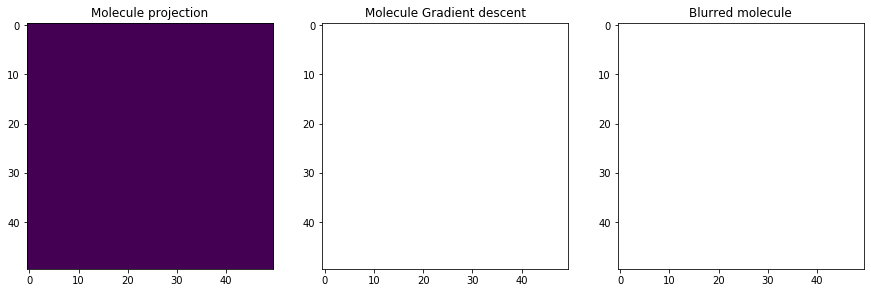

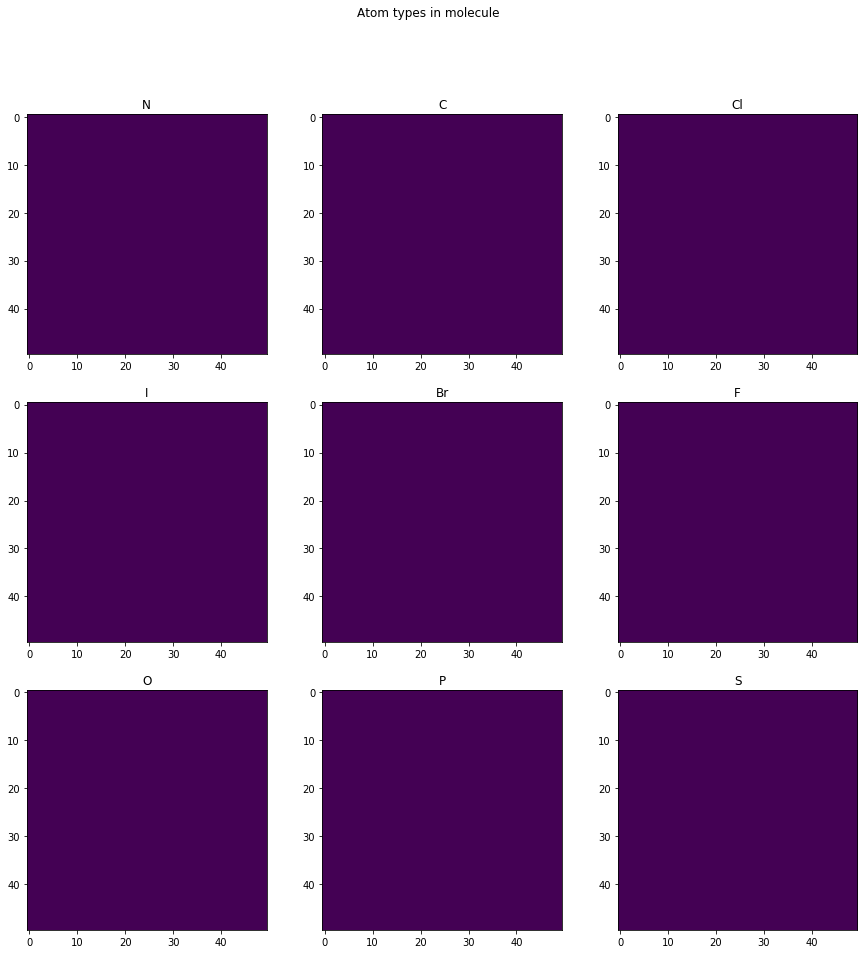

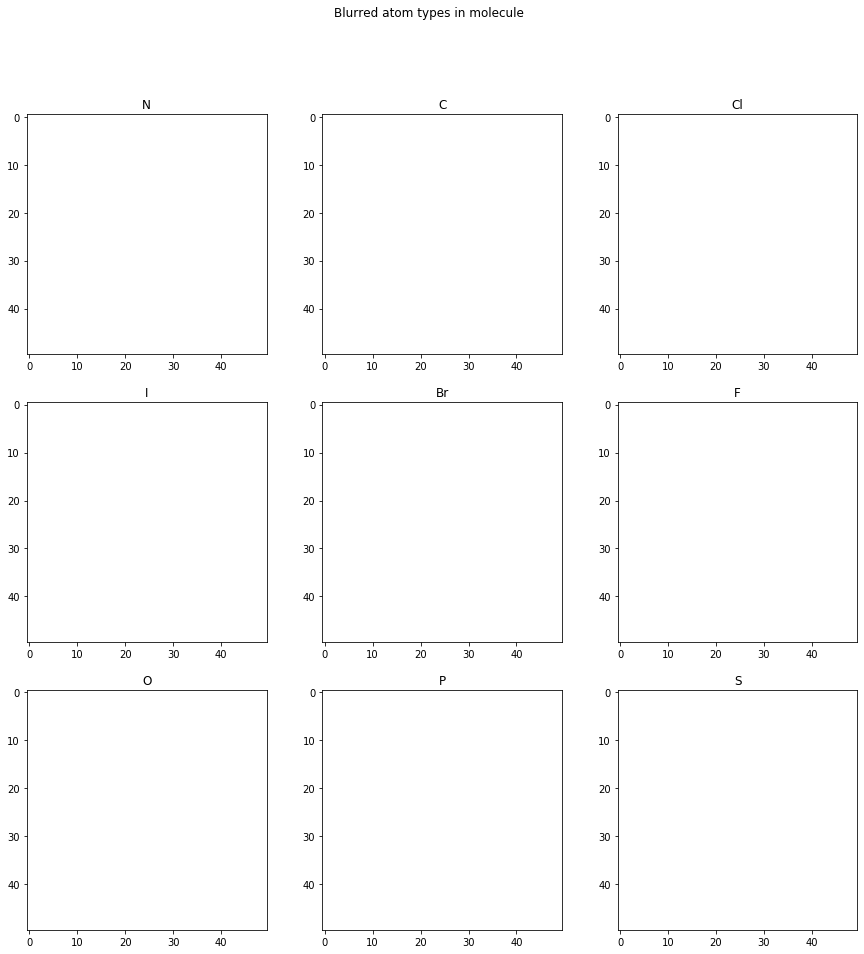

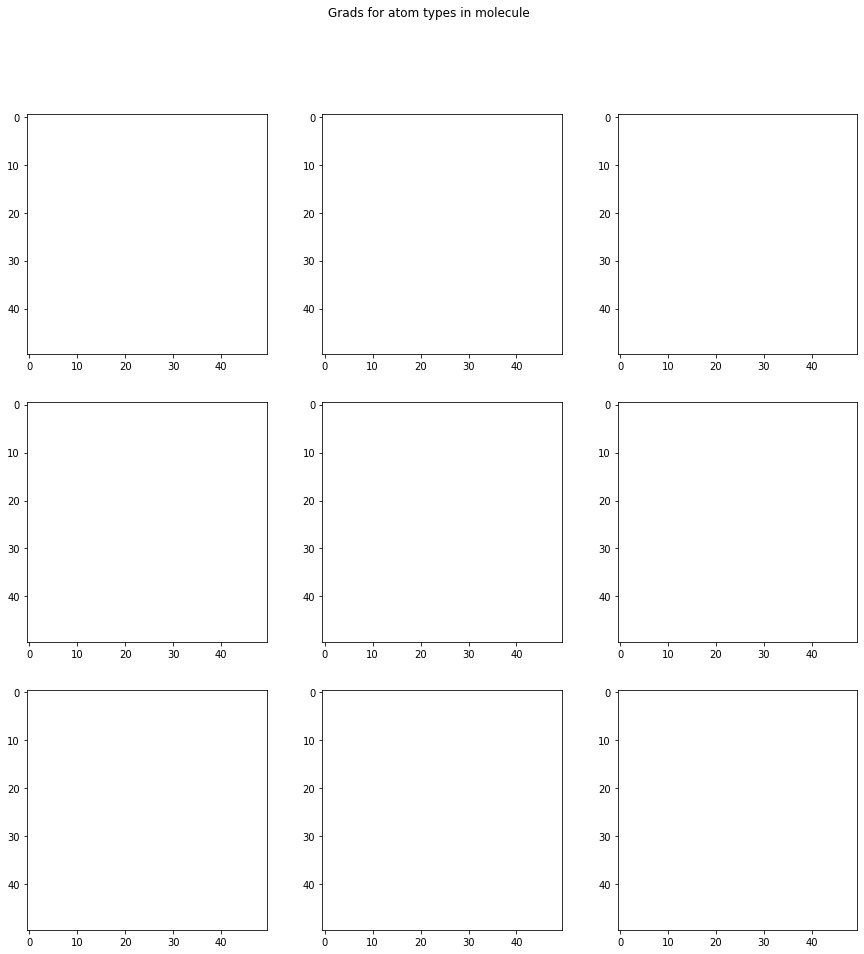

In [28]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='C=CCc1ccc(Oc2cc(CC=C)cc(O)c2O)cc1')

CC(C)(CO)CC(C)(C)c1nc2sc(C(C)(C)CC(C)(C)CO)nc2s1


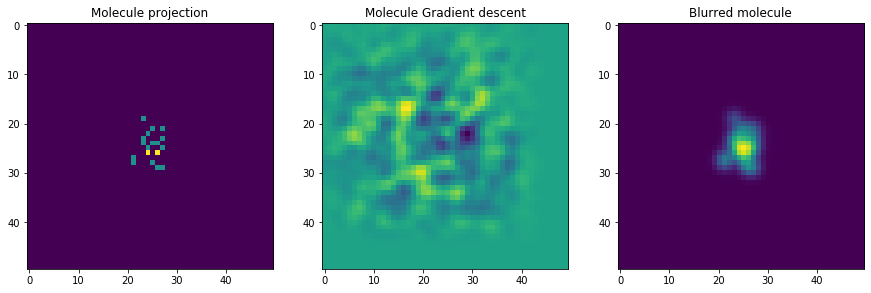

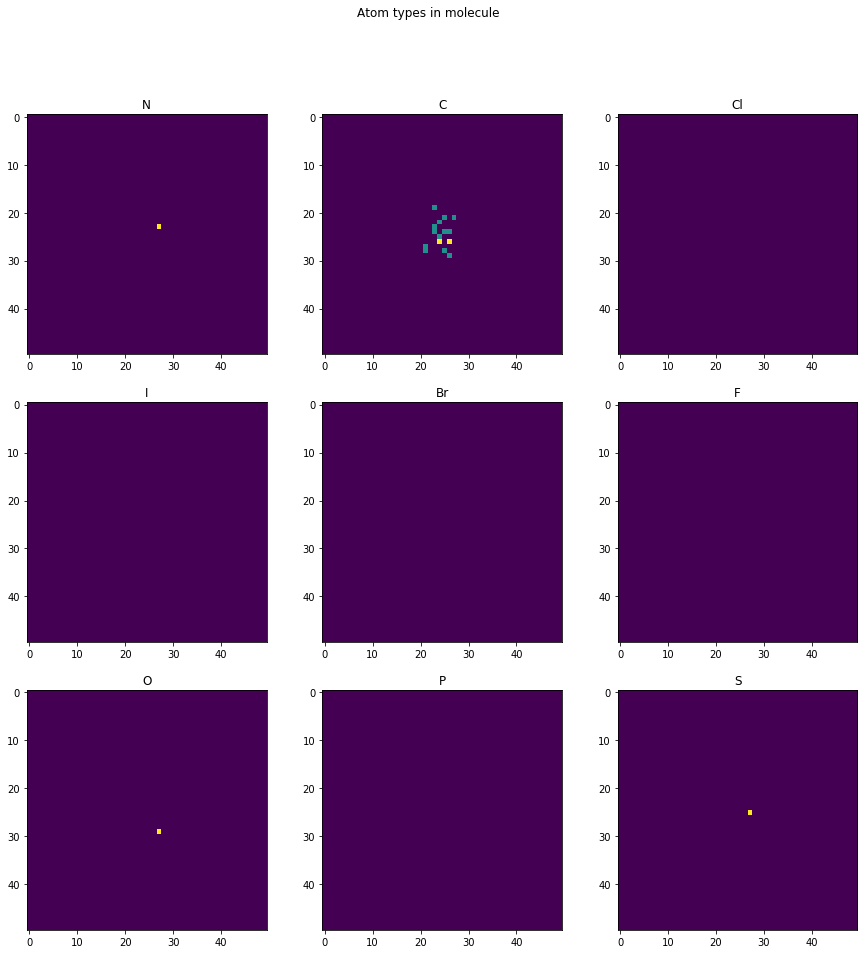

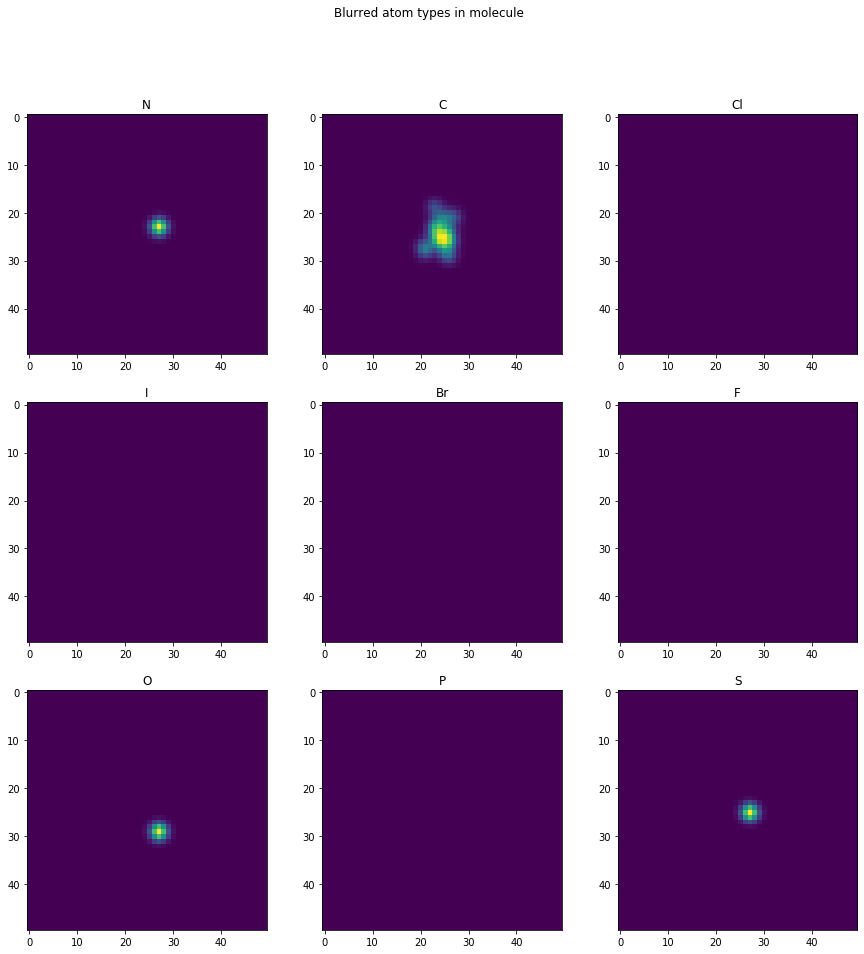

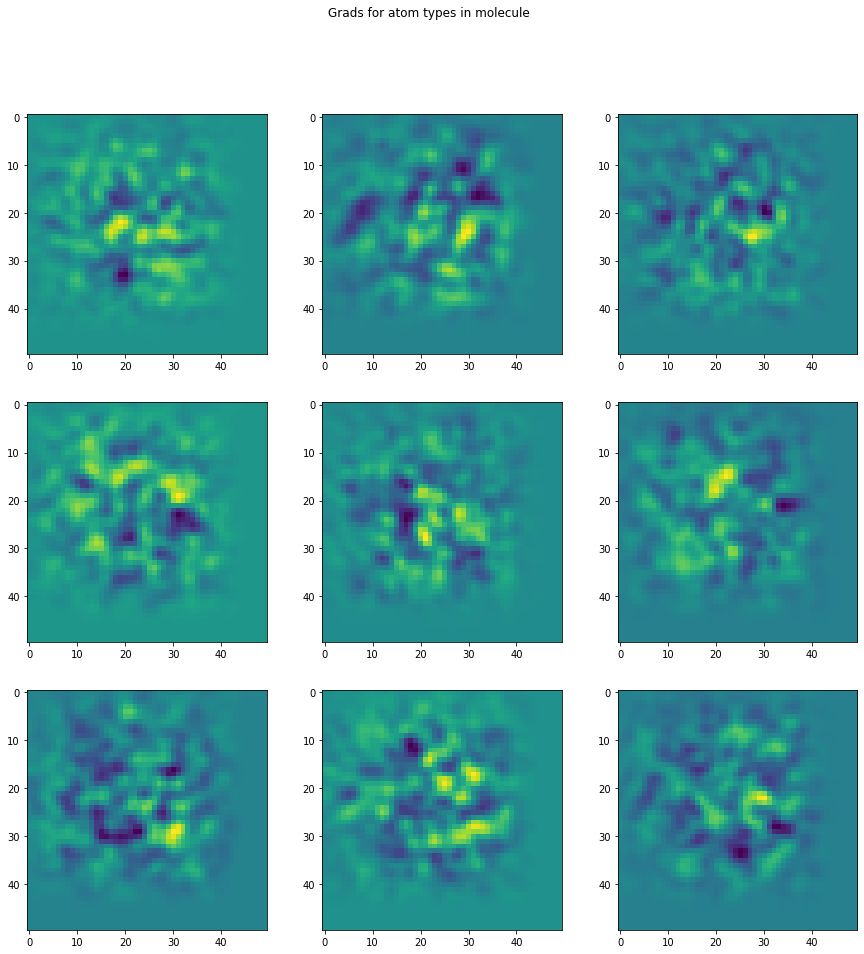

In [24]:
plot_visualization_input_as_parameter(model,elements,grad_step=10**3,name='CC(C)(CO)CC(C)(C)c1nc2sc(C(C)(C)CC(C)(C)CO)nc2s1')

In [ ]:
from torch.nn import Parameter
optimizer = torch.optim.Adam(iter(Variable(molecule.to(device),requires_grad=True)), lr=1e1)

In [52]:
from torch.autograd import Variable
for batch_idx, (molecule, target) in enumerate(train_generator):
    if batch_idx<9:
        continue
    molecule = Variable(molecule.to(device),requires_grad=True)
    target = target.to(device)
    # set gradients to zero
    output = model(molecule)
    # create mask to get rid of Nan's in target
    mask = (target == target)
    output_masked = torch.masked_select(output, mask).type_as(output)
    target_masked = torch.masked_select(target, mask).type_as(output)
    criterion=nn.MSELoss()
    loss = criterion(output_masked, target_masked)
    
    break

CC(=O)O[C@H]1C[C@@H](c2ccccc2)N(C)C[C@@]1(C)OC(C)=O
C=CCCC1CC(=O)OC1=O
C/C=C(/C(=O)NC(N)=O)c1ccccc1
CC(N)C(C)c1ccccc1
CC1(C)C=C(C(=O)NCCNC(=O)COc2ccc(Cl)cc2Cl)C(C)(C)N1
CC(=O)NNCc1ccc(NC(C)=O)cc1
CC(C)c1ccccc1NC1=NCCO1
CC1(C)COC1(c1ccc(Cl)cc1)c1ccc(Cl)cc1
C=C(C)C12OC3(c4ccccc4)OC1C1C4OC4(CO)C(O)C4(O)C(=O)C(C)CC4C1(O3)C(C)C2OC(=O)c1ccccc1
CC(C)c1ccc2c(c1)CC[C@@H]1[C@]2(C)CCC[C@@]1(C)CNCCNC[C@]1(C)CCC[C@]2(C)c3ccc(C(C)C)cc3CC[C@H]21


In [33]:
for param in model.parameters():
    print(param)
    break

Parameter containing:
tensor([1.2000, 1.2001, 1.2000, 1.2000, 1.2000, 1.2000, 1.2000, 1.2000, 1.2000],
       device='cuda:0', requires_grad=True)


In [ ]:
model

ValueError: can't optimize a non-leaf Tensor

In [22]:
loss.backward()

CC(=O)O[C@H]1C[C@@H]2CCC3C4CCC(=O)[C@@]4(C)CCC3[C@@]2(C)C[C@@H]1[N+]1(C)CCCC1


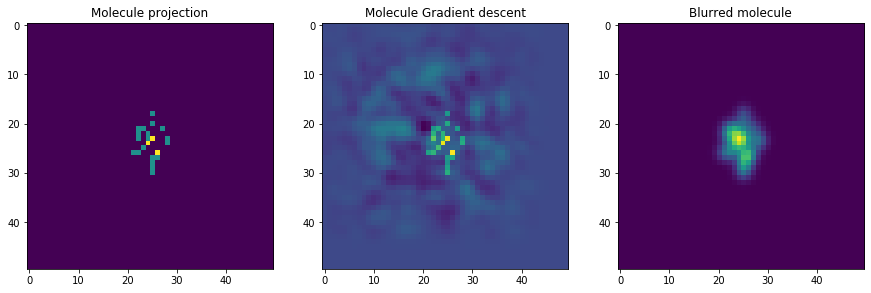

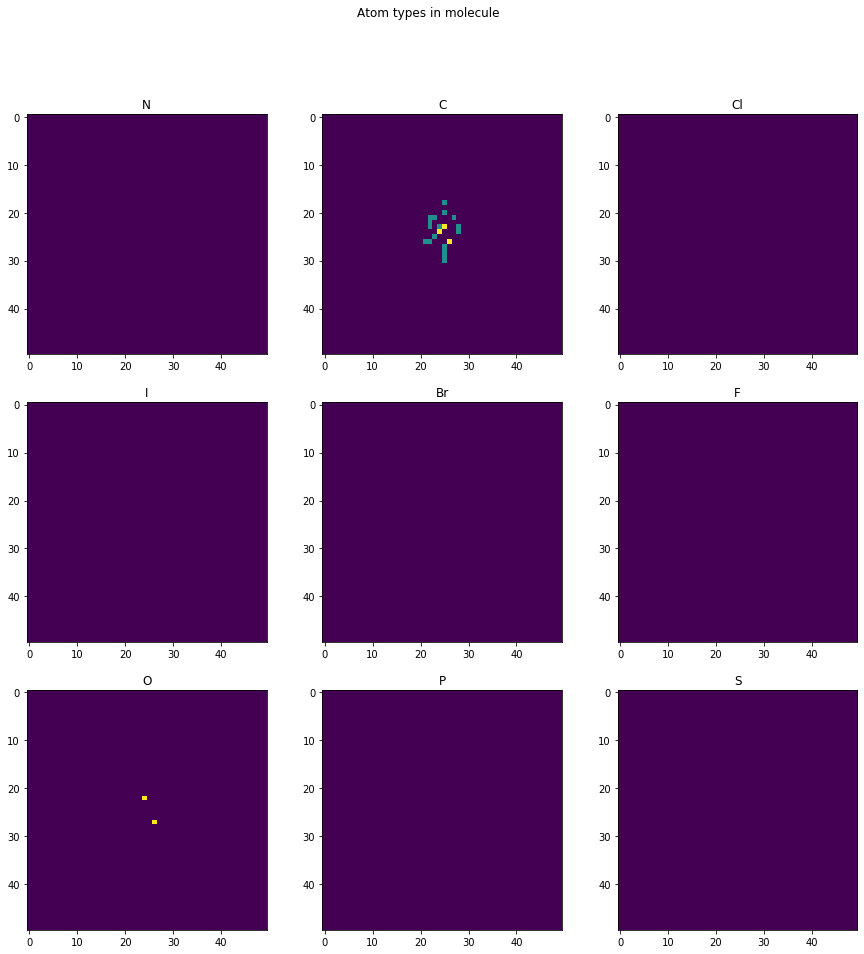

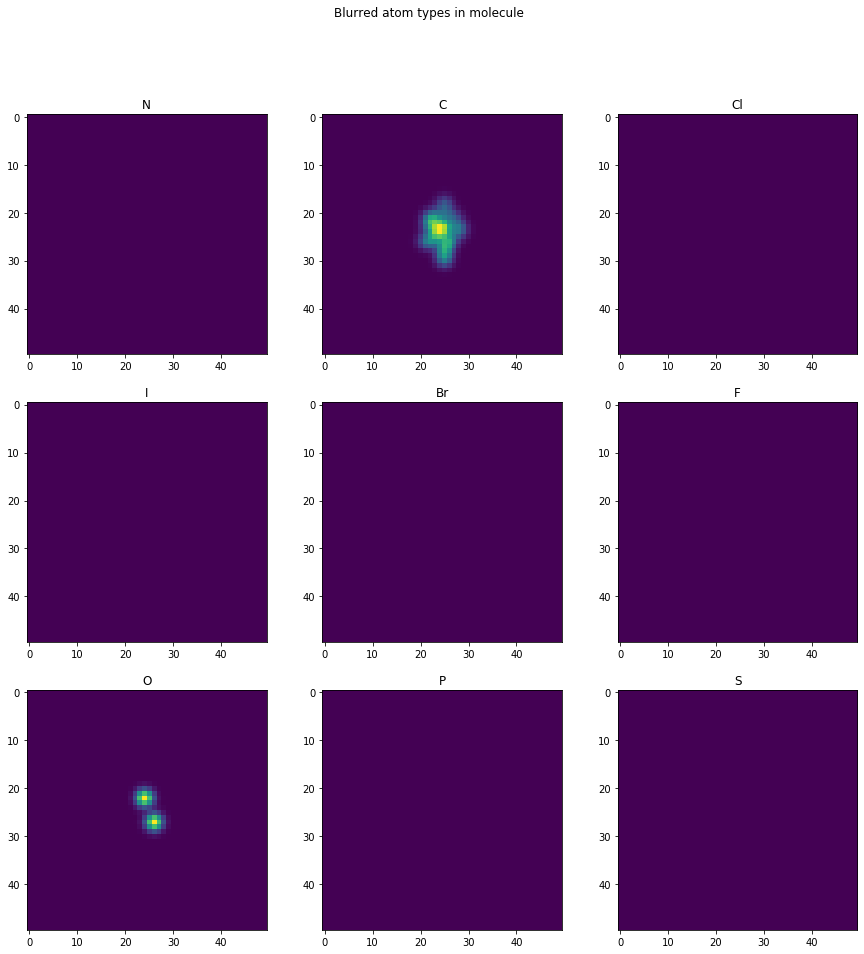

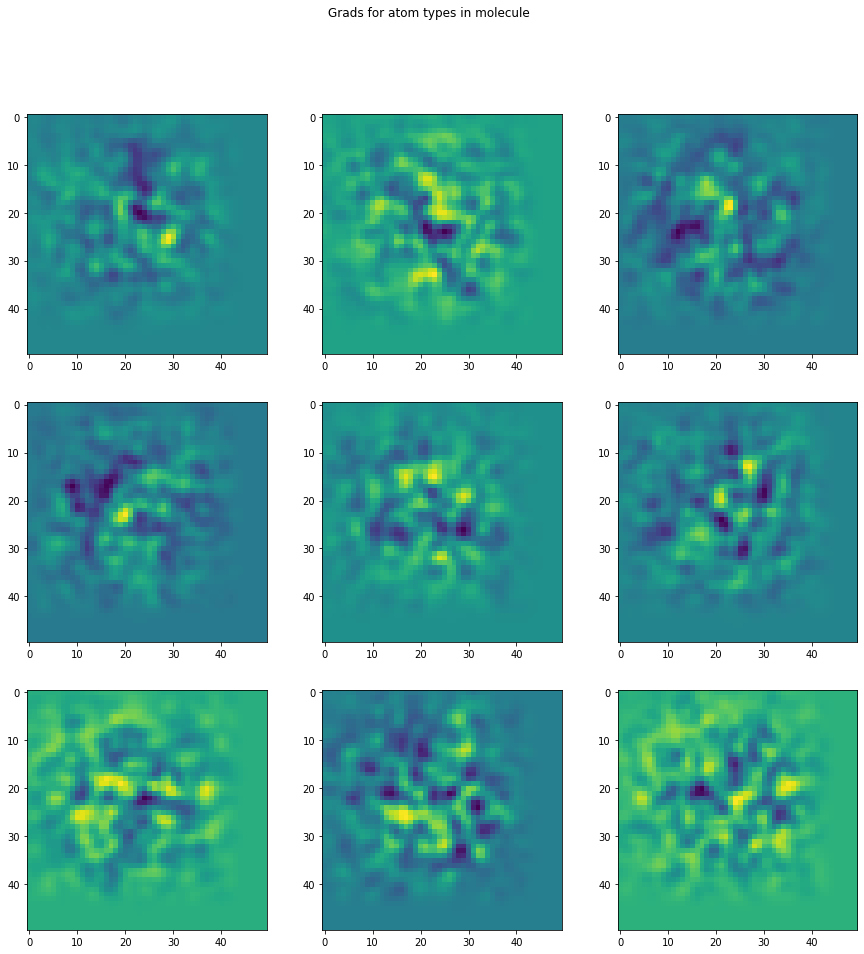

In [24]:
plot_visualization(data,model,elements,grad_step=10**3,name='CC(=O)O[C@H]1C[C@@H]2CCC3C4CCC(=O)[C@@]4(C)CCC3[C@@]2(C)C[C@@H]1[N+]1(C)CCCC1')

CC(C)OC(=O)C1=CCC[N+](C)(C)C1


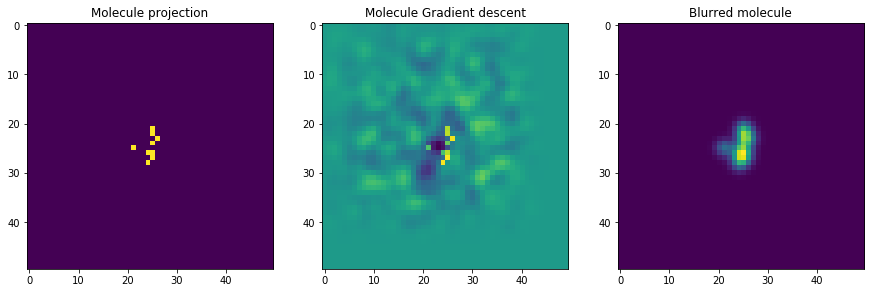

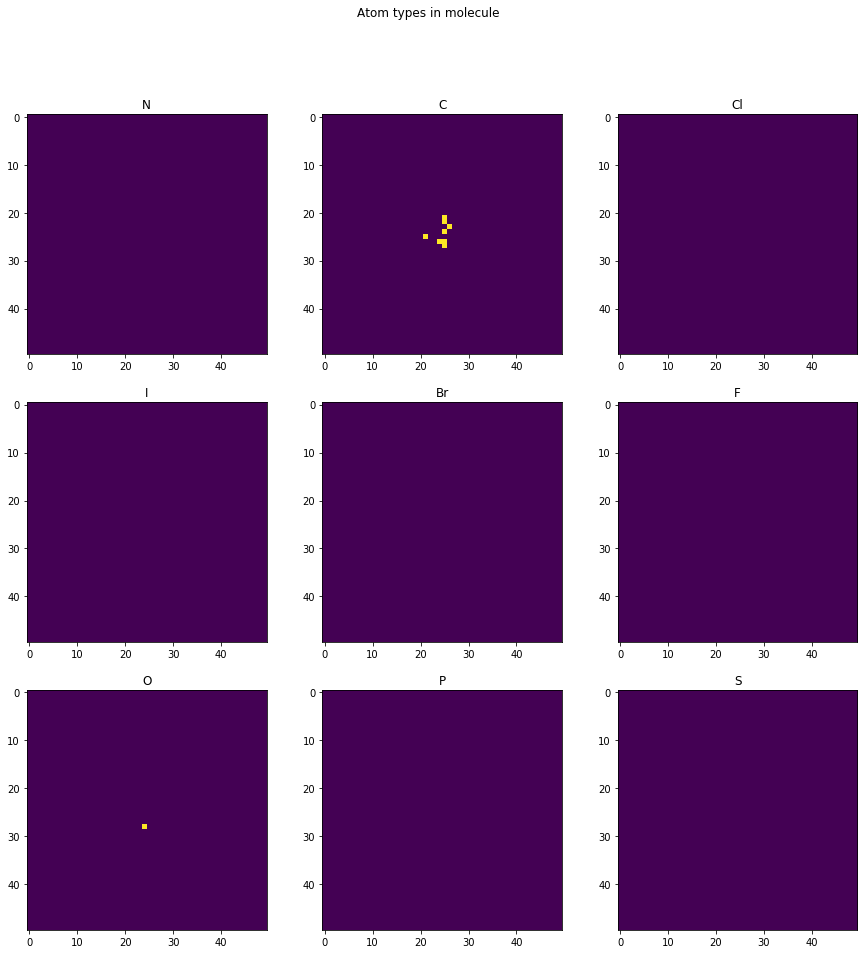

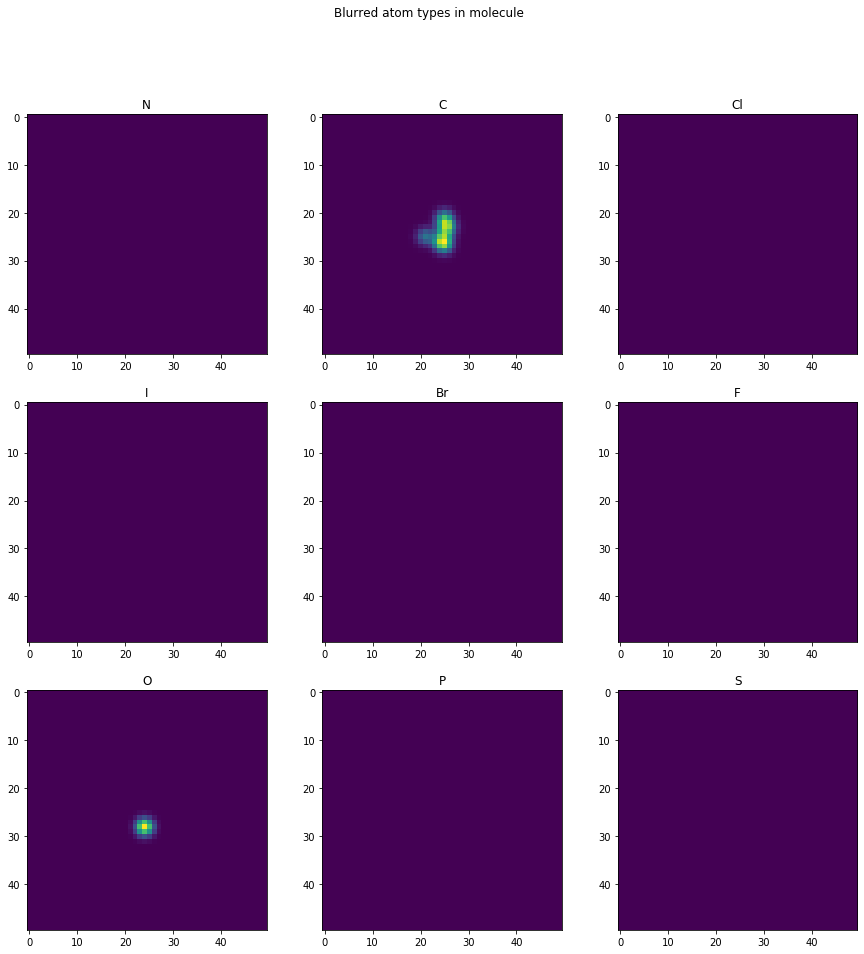

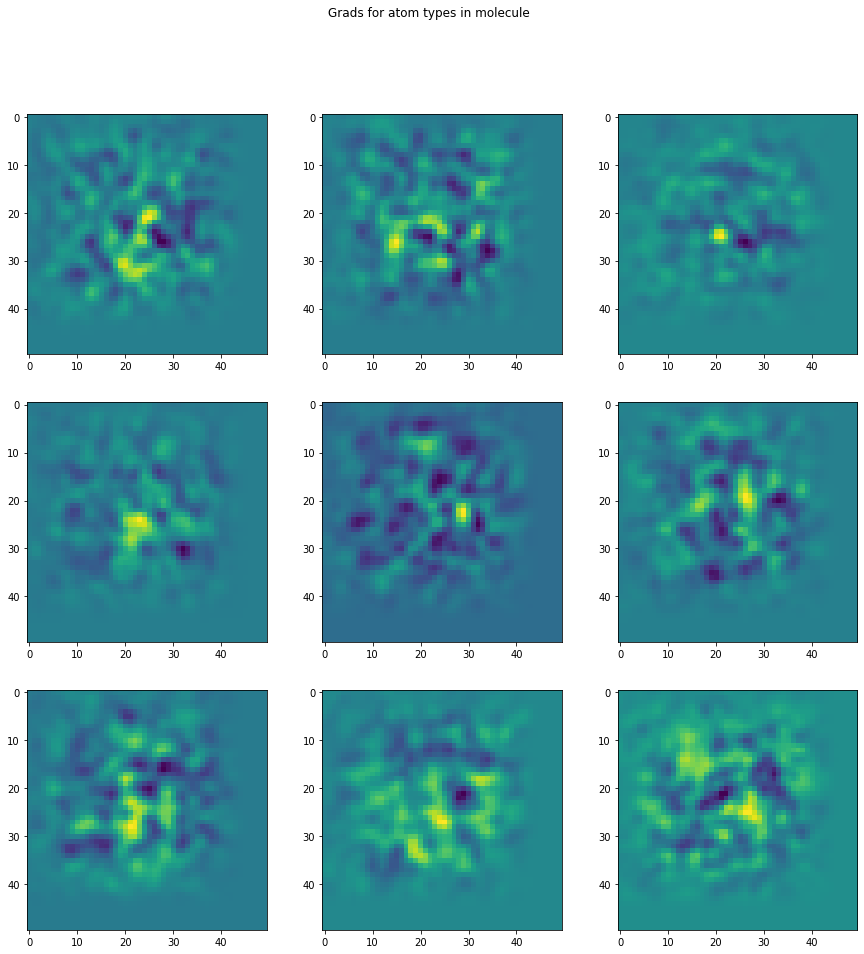

In [33]:
plot_visualization(data,model,elements,grad_step=10**3,name='CC(C)OC(=O)C1=CCC[N+](C)(C)C1')

C/C(=N/N1CCOCC1)c1csc(-c2ccc([N+](=O)[O-])s2)n1


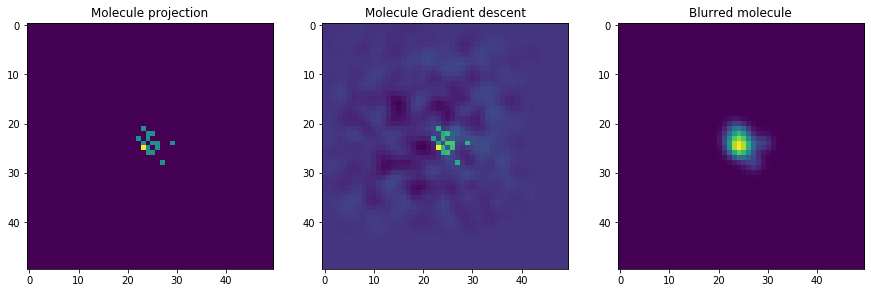

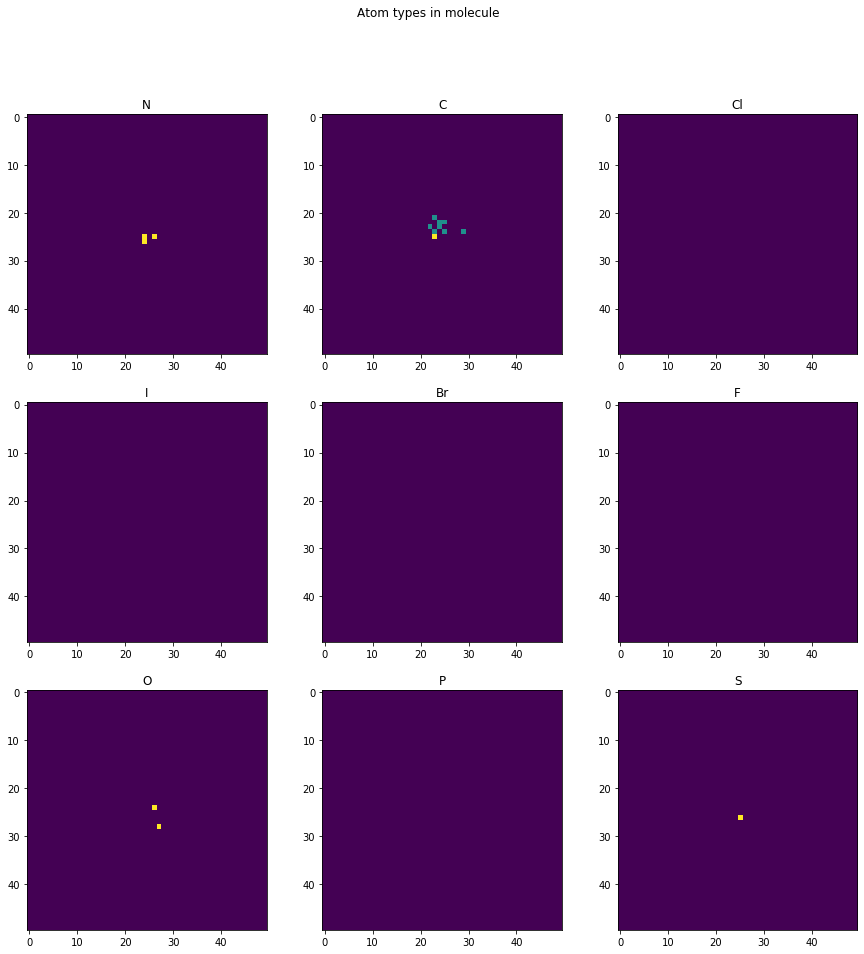

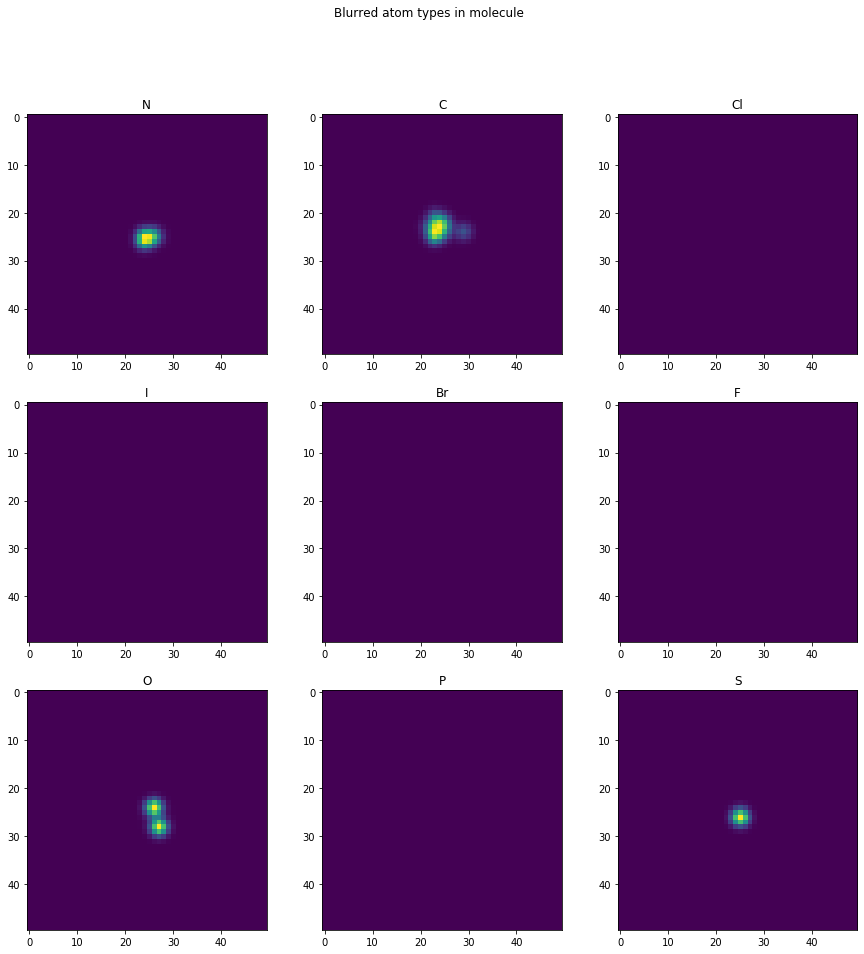

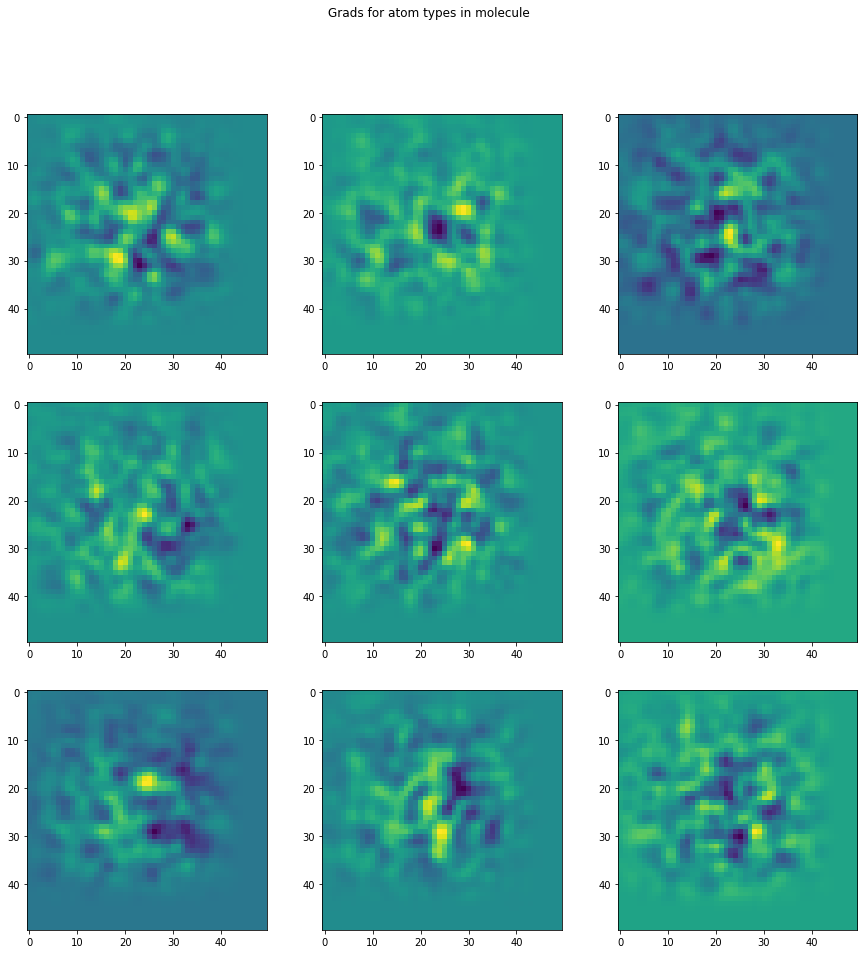

In [26]:
plot_visualization(data,model,elements,grad_step=10**3,name='C/C(=N/N1CCOCC1)c1csc(-c2ccc([N+](=O)[O-])s2)n1')

CC(C)=C1CC[C@H](C)[C@](C)(COc2ccc3ccc(=O)oc3c2)[C@H]1CCC(=O)O


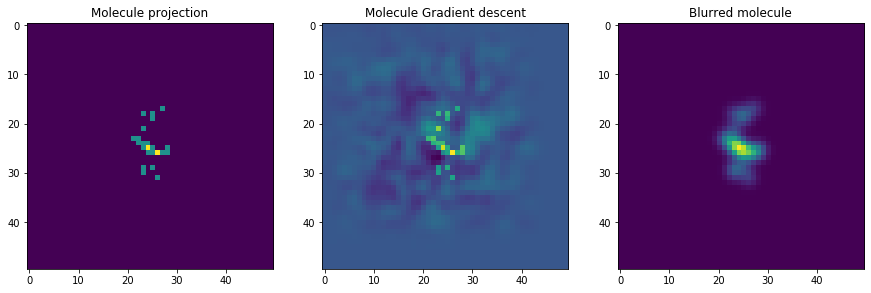

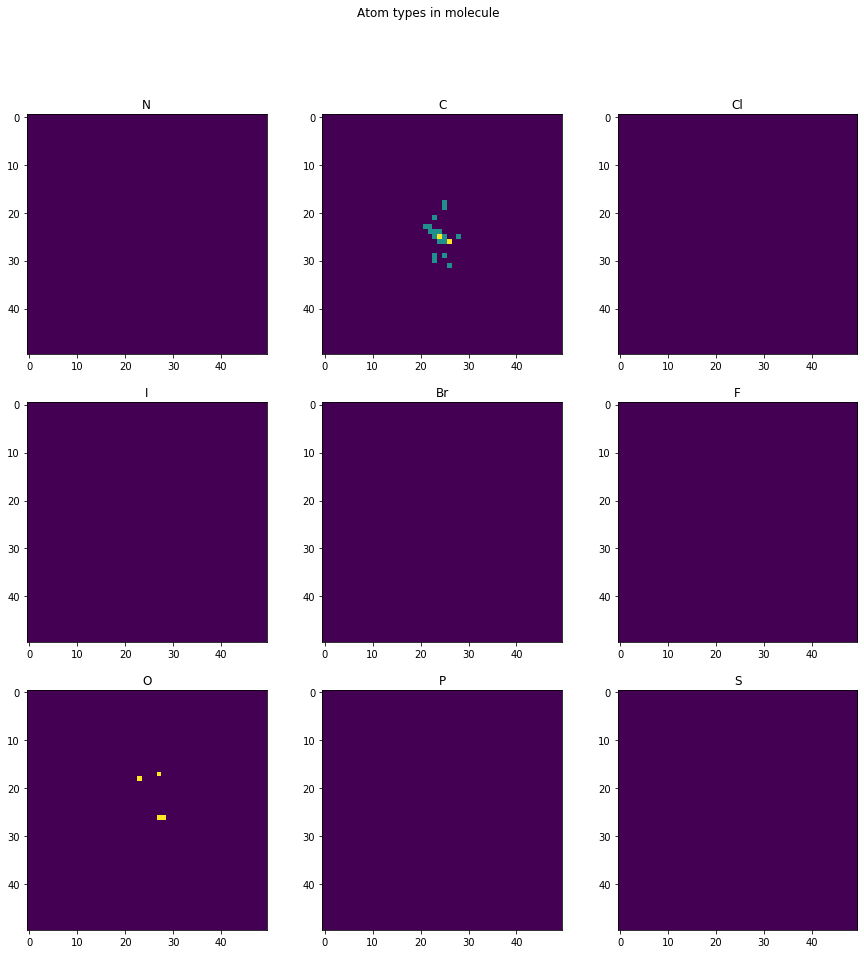

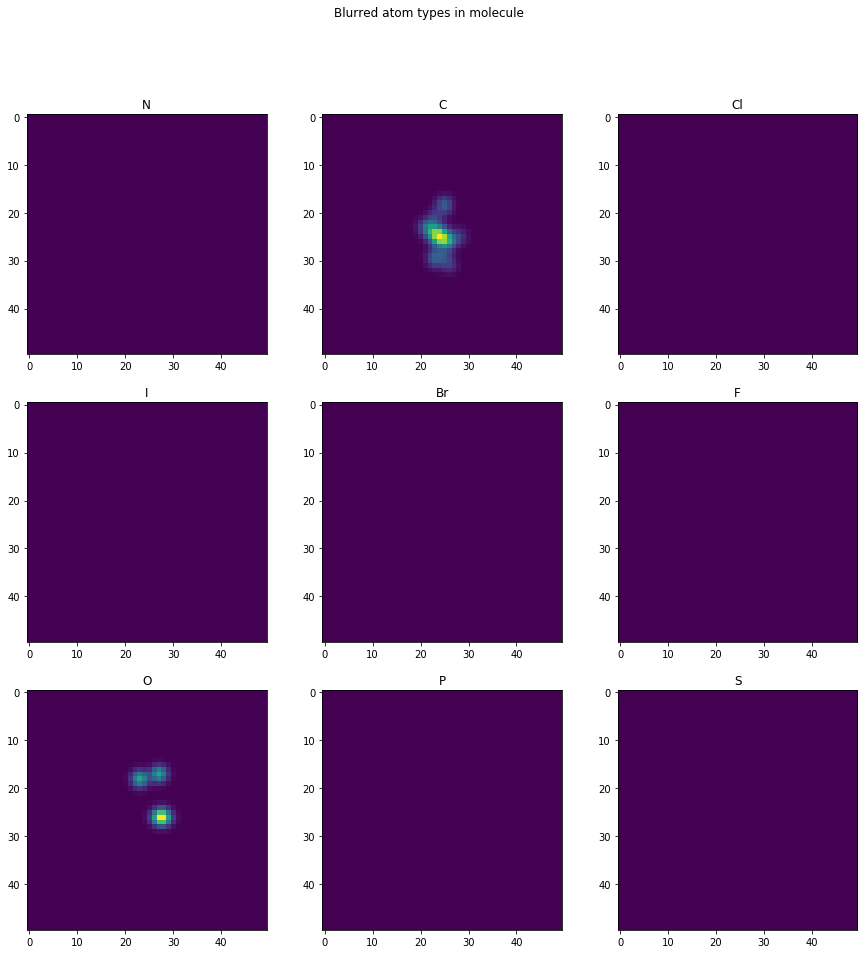

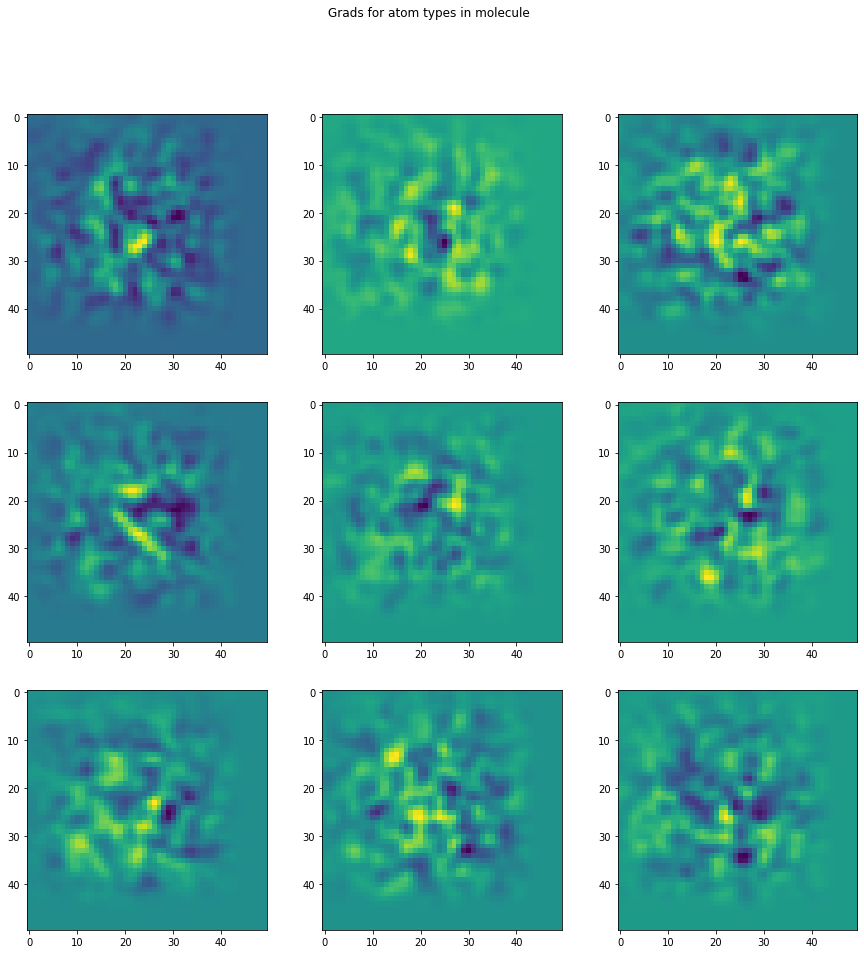

In [28]:
plot_visualization(data,model,elements,grad_step=10**3,name='CC(C)=C1CC[C@H](C)[C@](C)(COc2ccc3ccc(=O)oc3c2)[C@H]1CCC(=O)O')

CC(=O)N[C@H]1CO[C@@H]2[C@@H](O[N+](=O)[O-])CO[C@H]12


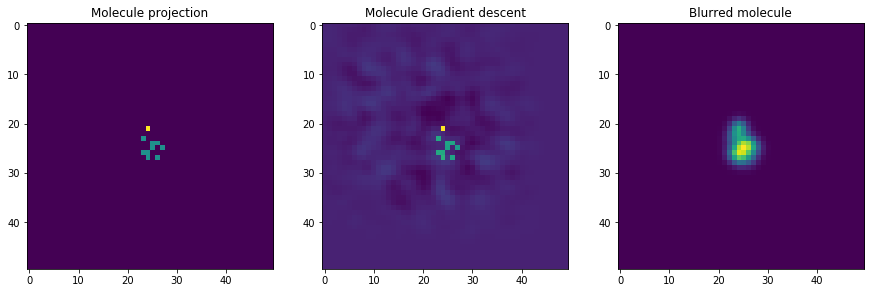

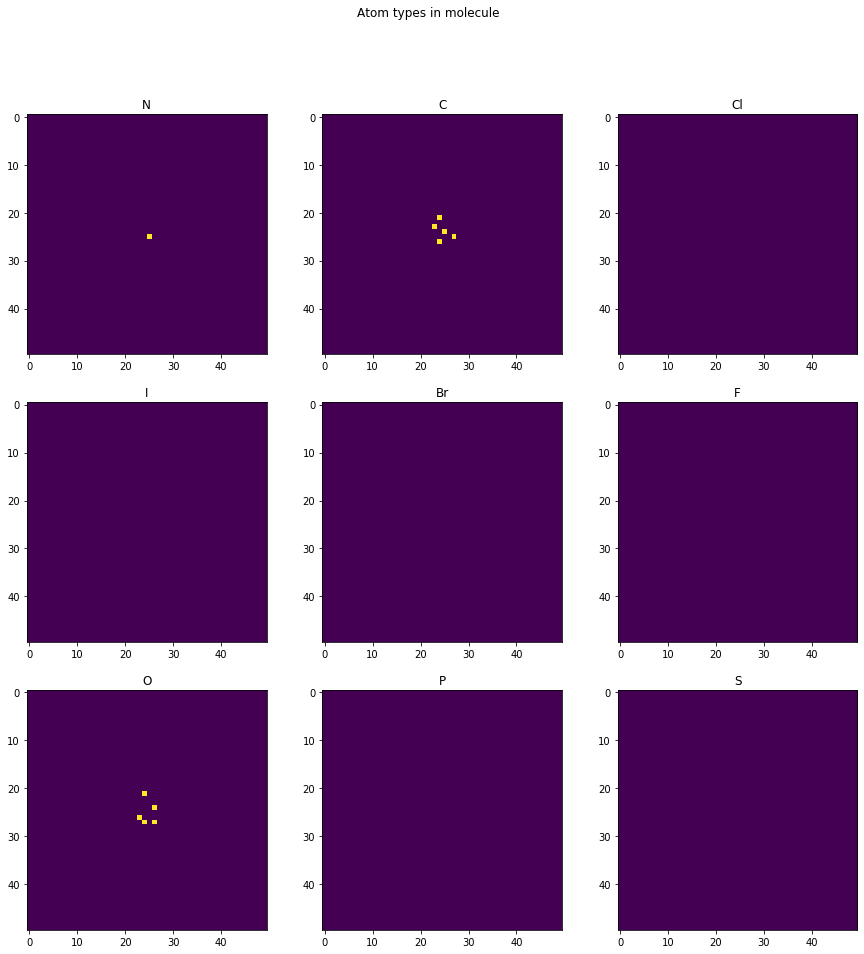

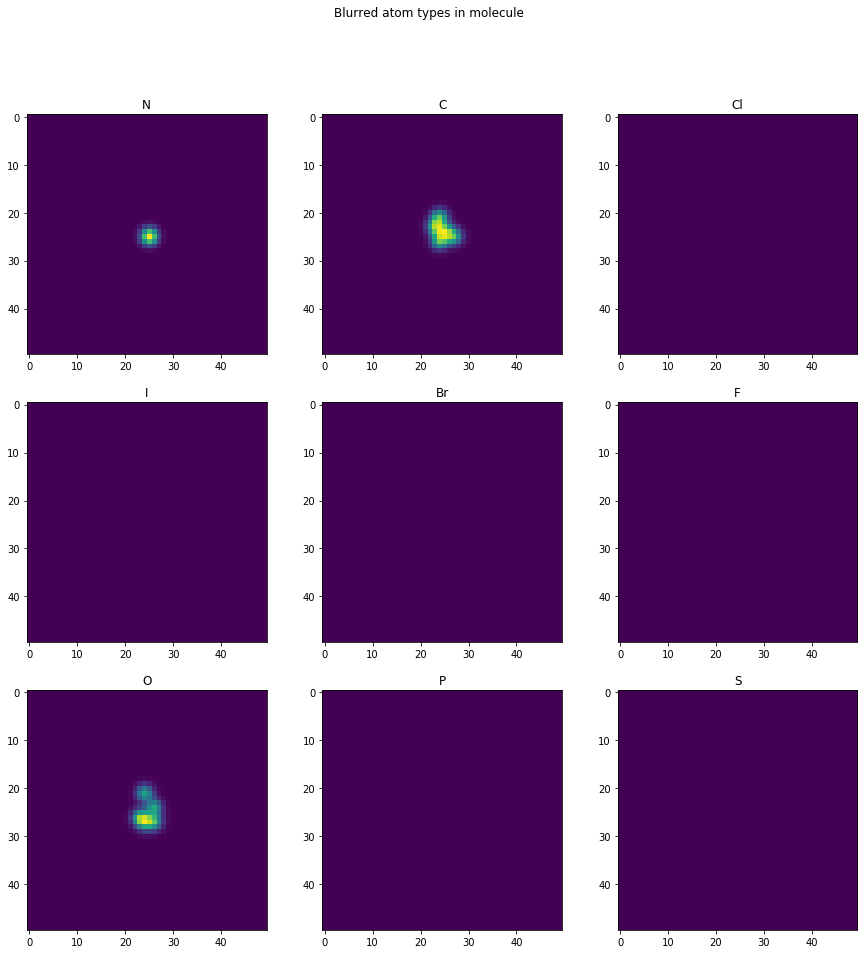

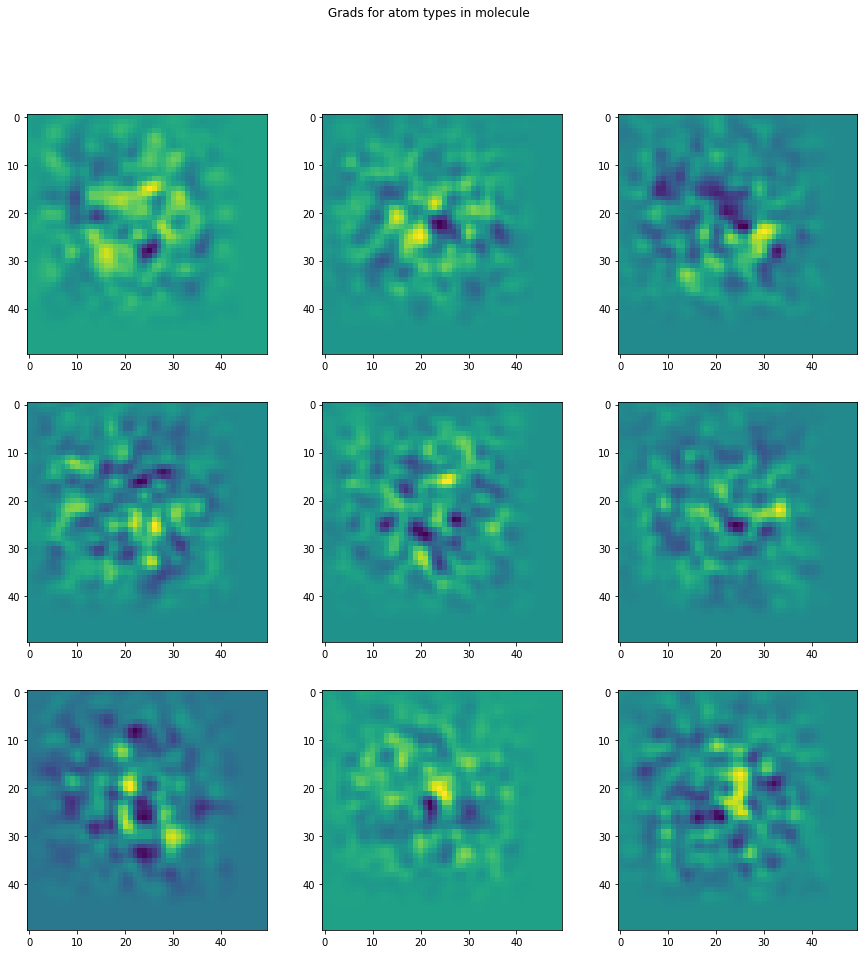

In [51]:
plot_visualization(data,model,grad_step=10**3,name='CC(=O)N[C@H]1CO[C@@H]2[C@@H](O[N+](=O)[O-])CO[C@H]12')

CC(=O)N[C@H]1CO[C@@H]2[C@@H](O[N+](=O)[O-])CO[C@H]12


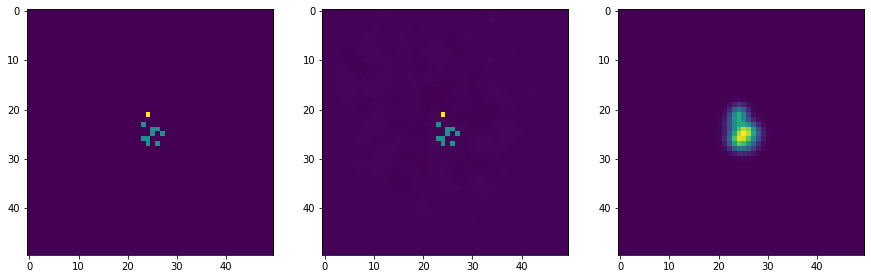

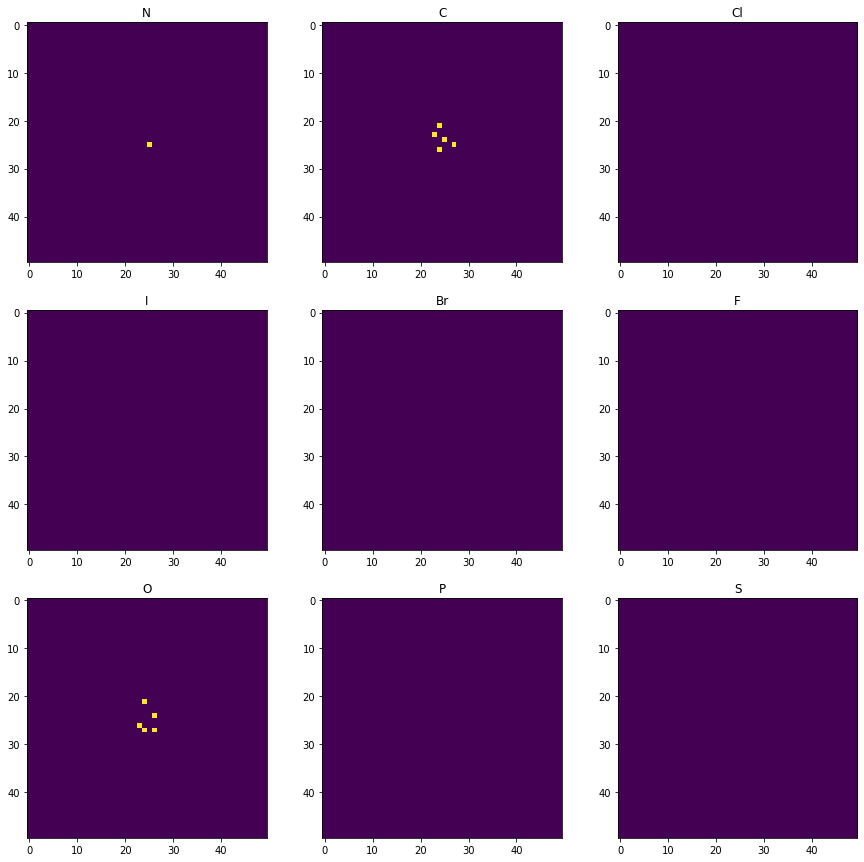

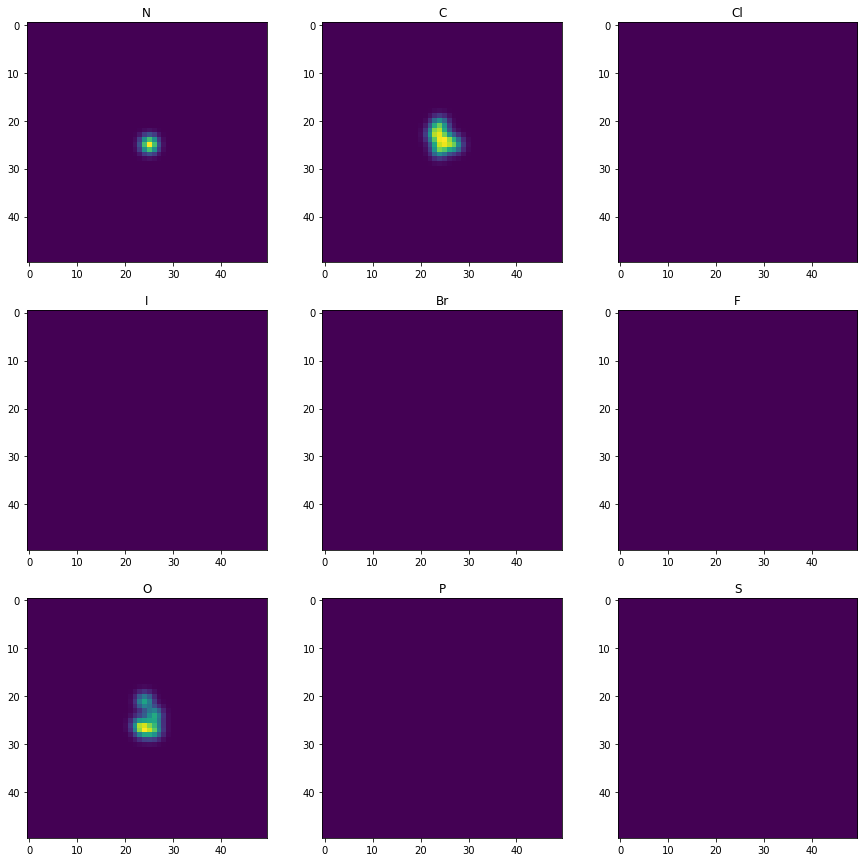

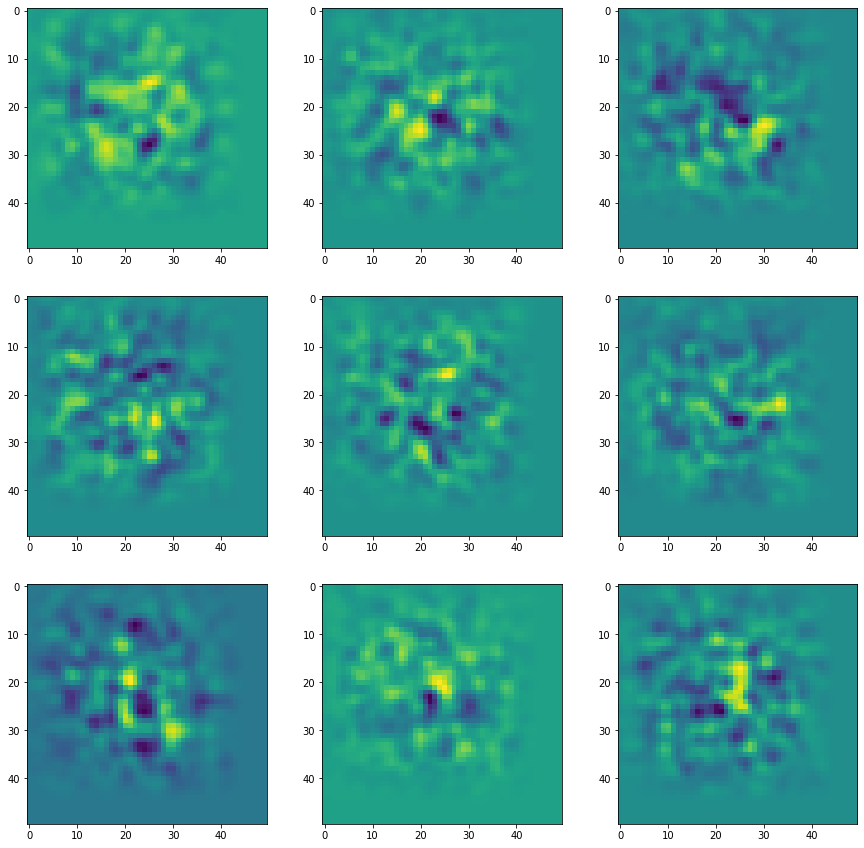

In [49]:
import matplotlib.pyplot as plt

print('CC(=O)N[C@H]1CO[C@@H]2[C@@H](O[N+](=O)[O-])CO[C@H]12')

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

ax[1].imshow((data-10**2*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

with torch.no_grad():
    gauss_blur = model.blur(data)
    
ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
plt.show()
molecules = data.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(molecules):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    ax[i//3,i%3].set_title(inv_elems[i])
plt.show()
molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(molecules_blur):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    ax[i//3,i%3].set_title(inv_elems[i])
plt.show()
grads = data.grad.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(grads):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    

C=CCn1c(=O)cc(N)n(CC)c1=O


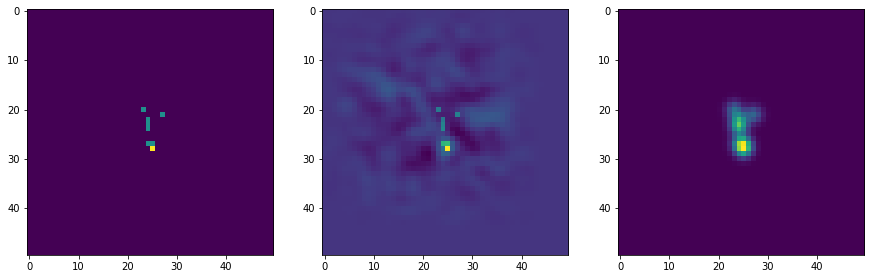

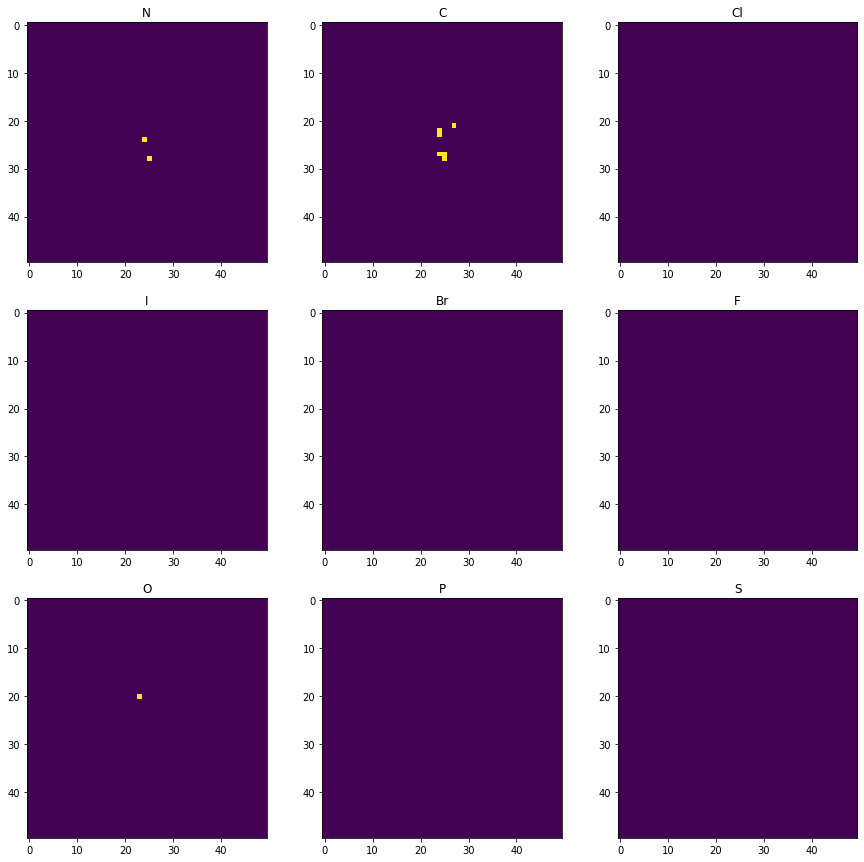

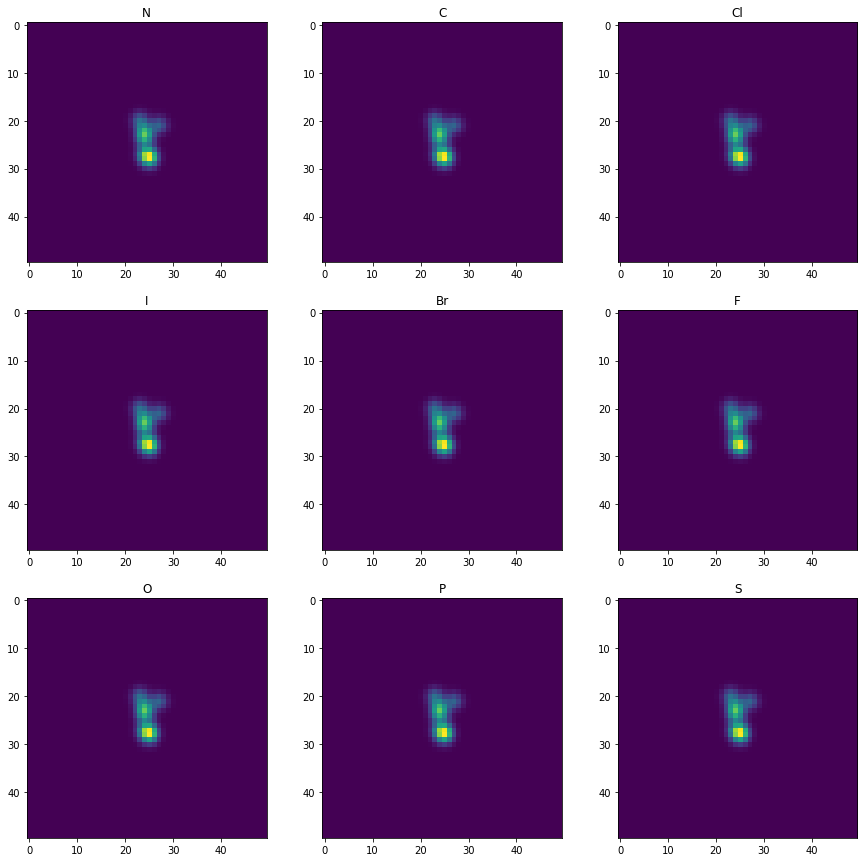

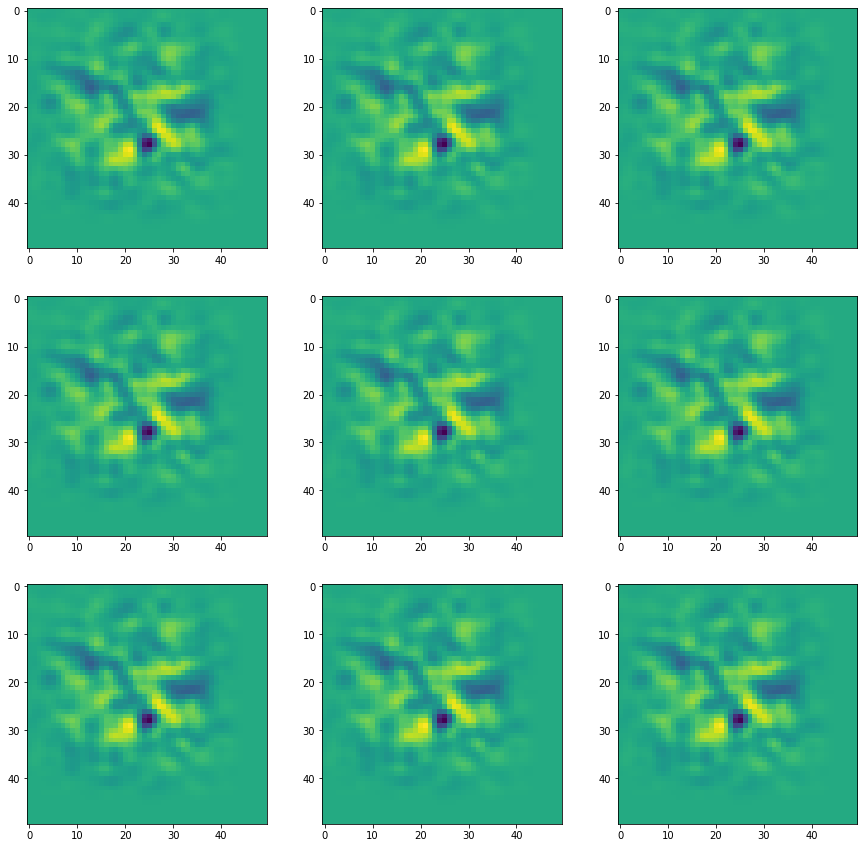

In [34]:
import matplotlib.pyplot as plt

print('C=CCn1c(=O)cc(N)n(CC)c1=O')

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

ax[1].imshow((data-100*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

with torch.no_grad():
    gauss_blur = model.blur(data)
    
ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
plt.show()
molecules = data.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(molecules):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    ax[i//3,i%3].set_title(inv_elems[i])
plt.show()
molecules_blur = gauss_blur.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(molecules_blur):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    ax[i//3,i%3].set_title(inv_elems[i])
plt.show()
grads = data.grad.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(grads):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    

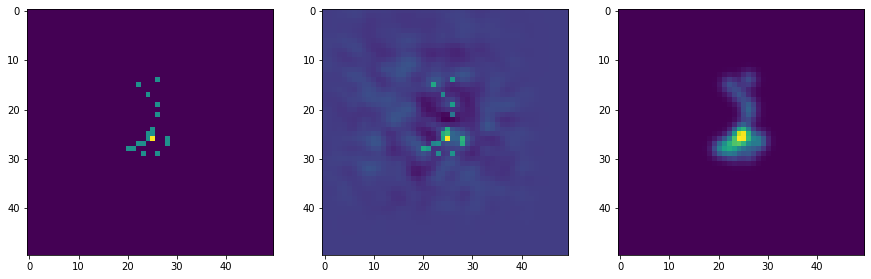

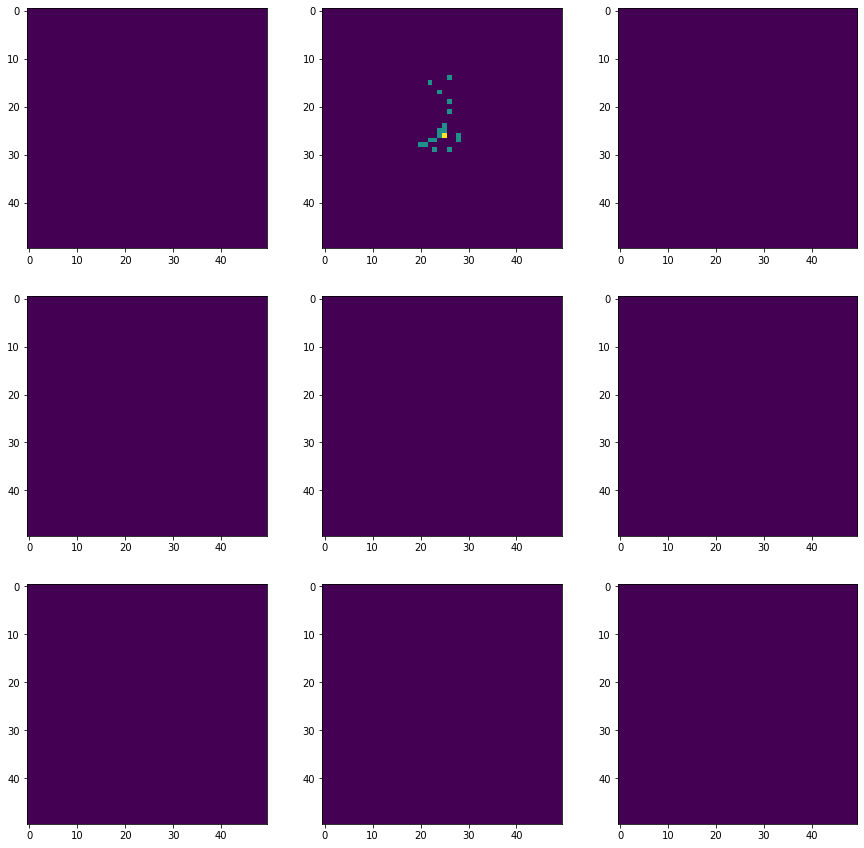

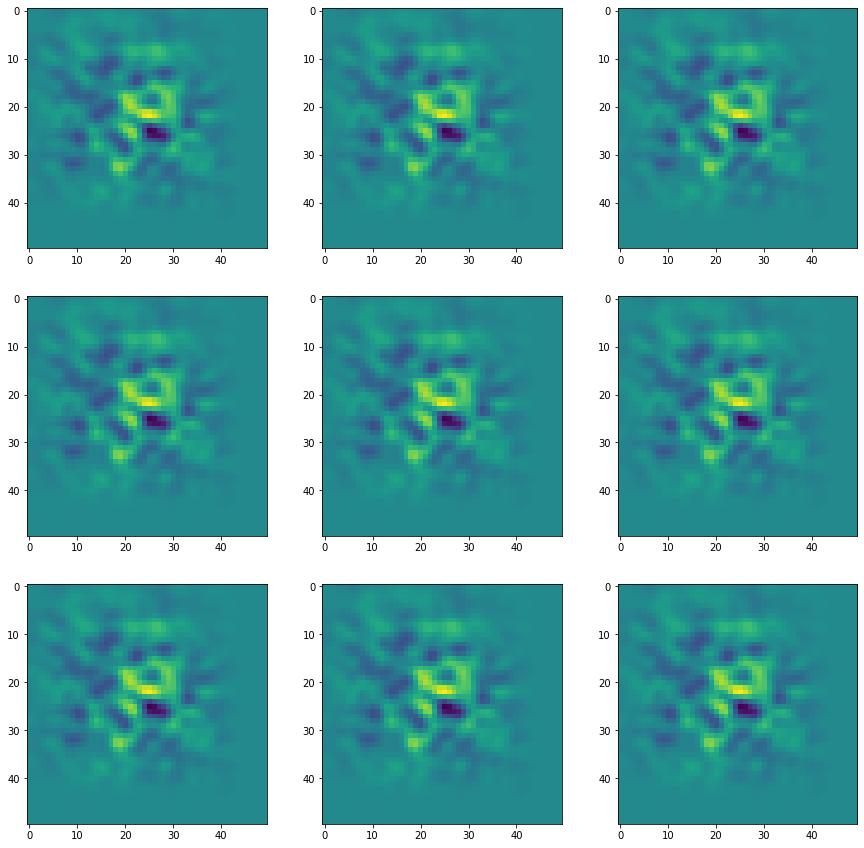

In [70]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

ax[1].imshow((data-100*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

with torch.no_grad():
    gauss_blur = model.blur(data)
    
ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
plt.show()
molecules = data.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(molecules):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
plt.show()
grads = data.grad.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(grads):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    

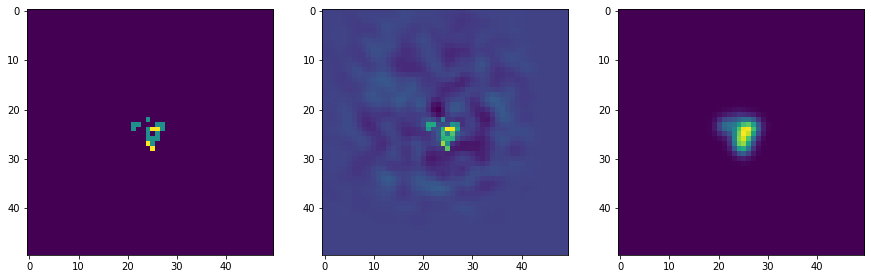

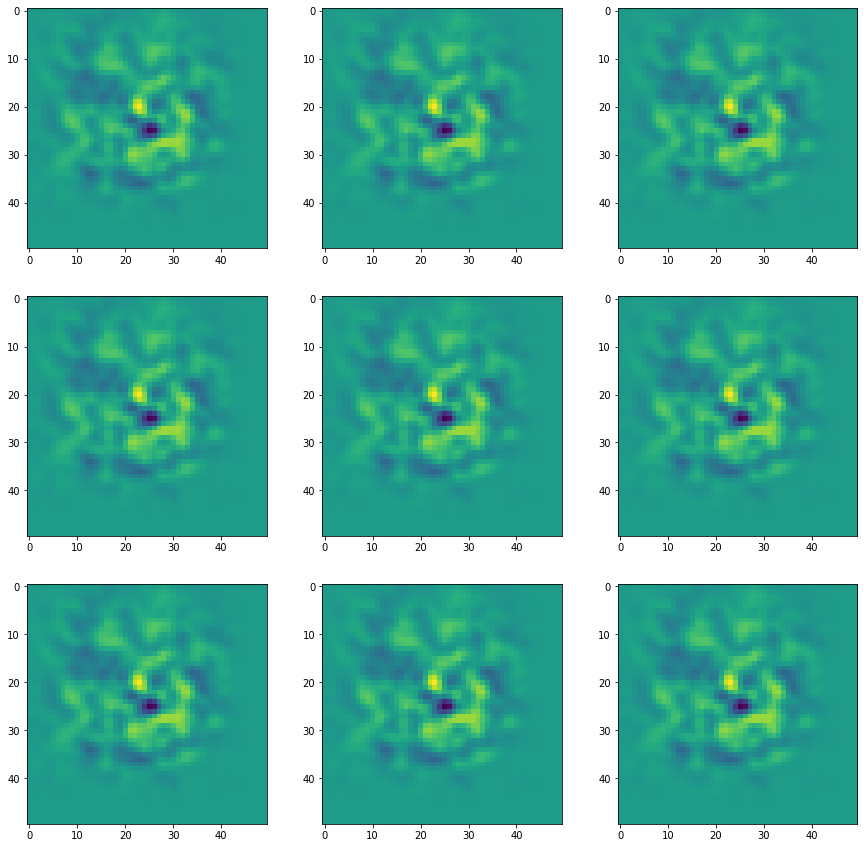

In [64]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

ax[1].imshow((data-100*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

with torch.no_grad():
    gauss_blur = model.blur(data)
    
ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
plt.show()
grads = data.grad.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(grads):
    ax[i//3,i%3].imshow(grad.sum(dim=0))

CC(C)C(CCN(C)C)(C(N)=O)C(C)C


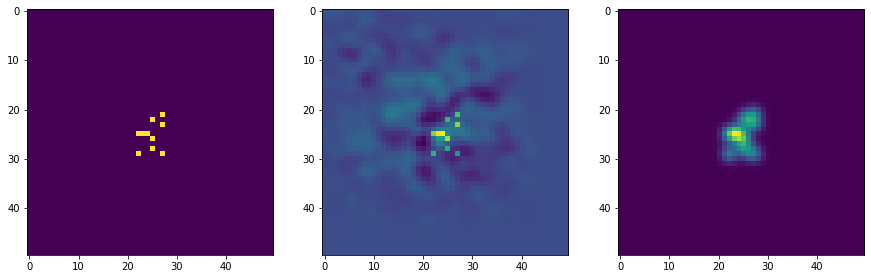

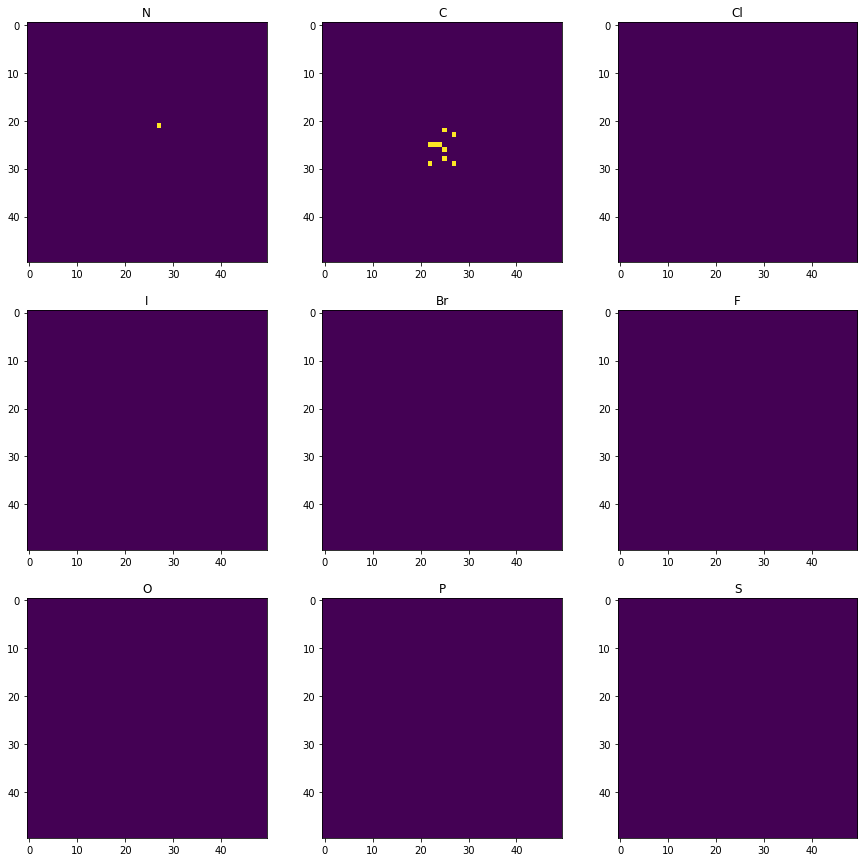

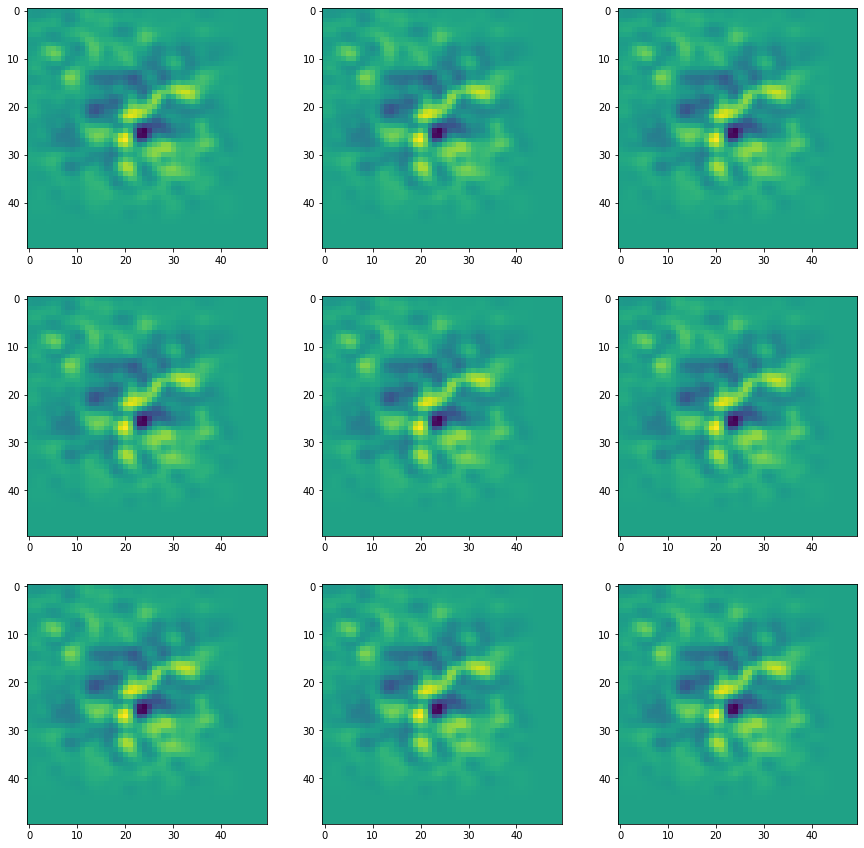

In [30]:
import matplotlib.pyplot as plt

print('CC(C)C(CCN(C)C)(C(N)=O)C(C)C')

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(data.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

ax[1].imshow((data-100*data.grad).cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))

with torch.no_grad():
    gauss_blur = model.blur(data)
    
ax[2].imshow(gauss_blur.cpu().detach().sum(dim=0).sum(dim=0).sum(dim=0))
plt.show()
molecules = data.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(molecules):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    ax[i//3,i%3].set_title(inv_elems[i])
plt.show()
grads = data.grad.cpu().detach().sum(dim=0)

fig,ax = plt.subplots(3,3,figsize=(15,15))
for i,grad in enumerate(grads):
    ax[i//3,i%3].imshow(grad.sum(dim=0))
    

In [29]:
inv_elems

{0: 'N', 1: 'C', 2: 'Cl', 3: 'I', 4: 'Br', 5: 'F', 6: 'O', 7: 'P', 8: 'S'}

In [28]:
inv_elems = {v: k for k, v in elements.items()}